In [200]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import pprint
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import gensim
import os.path
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

#curent directory
cwd = os.getcwd()

#key for newsapi
key = 'd6f155038c014316a4e9622dab7b1a5e'

In [369]:
query = input('What industy/ region topics are you interested in? ')
#See doc for supported industry/ region
#query = input('Which industry are you interested in? ') if cat == 'industry' else input('Which industry are you interested in? ')

What industy/ region topics are you interested in? US technology news


# News Search

In [210]:
articles=[]
page = 1
url = 'https://newsapi.org/v2/everything'
while True:
    # reference: https://newsapi.org/docs
    r = requests.get(url, params={'apiKey': key,'q': query,'pageSize':100, 'language':'en', 'page':page, 'sortby': 'relevancy'})
    r_j = r.json()
    if r_j['status']=='error' or r_j['articles']==[]:
        print ('All atricles retreived')
        break
    print ('page: ', page)
    print (r_j['articles'][0]['title'])
    print (r_j['articles'][0]['publishedAt'])
    articles += r.json()['articles']
    page+=1
print (len(articles))
df = pd.DataFrame(articles)
now = datetime.now().strftime("%Y-%m-%d")
df.to_csv(cwd+'/Articles/{}_{}_articles.csv'.format(now, query))

page:  1
Dow, S&P slip as energy, financials weigh; tech boosts Nasdaq
2018-10-22T17:57:00Z
page:  2
Wall Street drops as China support fades, earnings disappoint
2018-10-22T14:51:47Z
page:  3
Dollar hits 16-month high; tech woes crunch stocks
2018-11-12T19:35:38Z
page:  4
Cryptoniteファウンダー 「Tony Perkins」氏がインフルエンサーのシェアリングエコノミー”PATRON”のアドバイザリーボードに就任
2018-10-27T14:12:49Z
page:  5
Cryoport to Report Third Quarter 2018 Financial Results on November 8th, 2018
2018-10-30T12:30:00Z
page:  6
RCM Technologies, Inc. (RCMT) Management on Q3 2018 Results - Earnings Call Transcript
2018-11-09T19:04:03Z
page:  7
Alithya Files Financial Results for the First Six Months of FY2019
2018-11-14T13:00:00Z
page:  8
Cyber Security ETFs to Shine on Robust Earnings
2018-11-14T15:11:00Z
page:  9
News Corp (NWSA) CEO Robert Thomson on Q1 2019 Results - Earnings Call Transcript
2018-11-08T01:56:21Z
page:  10
Bitcoin Price Steady Amidst Global Stock Market Sell-off
2018-10-30T13:00:00Z
All atricles retreived
1000


# tf-idf model

In [212]:
            a_df = pd.read_csv(cwd+'/Articles/2018-11-21_'+query+'_articles.csv',index_col=0)
            #Data cleaning
            a_df.dropna(axis=0, subset=['title', 'content', 'publishedAt'], inplace=True)
            a_df.sort_values('publishedAt', inplace=True)
            #add column to represent count of each topic (before grouping)
            a_df['count']=1
            a_df['publishedAt'] = pd.to_datetime(a_df['publishedAt'])
            a_df.reset_index(drop=True, inplace=True)
            output_df = a_df.copy(True)
            exclude =[]
            grp = {}
            #Each article is a grp of its own in the beginning
            for ix in a_df.index:
                grp[ix] = ix
            #display(output_df.head(10))
            #Evaluate each article
            for index, row in a_df.iterrows():
                #continue if article already removed
                if index in exclude:
                    continue
                date = row['publishedAt']
                start_date = date - timedelta(days=1)
                end_date = date+ timedelta(days=1)
                print ('date:{}, start_date: {}, end_date: {}'.format(date,start_date,end_date))
                #Filter articles within +- 1 day
                sub_df = a_df[(a_df['publishedAt'] >= start_date) & (a_df['publishedAt'] <= end_date)]
                sub_titles = sub_df['title'].tolist()
                sub_contents = [c[:-10] for c in sub_df['content'].tolist()]

                #Tokenize the artcle content
                sub_df['token_list'] = [[w.lower() for w in word_tokenize(t)] for t in sub_df['content']]
                #Create dictionary with the tokens
                word_dict = gensim.corpora.Dictionary(sub_df['token_list'])
                #print("Number of words in dictionary:",len(word_dict))
        
                #Create corpus: lists the number of times each word occurs a title
                corpus = [word_dict.doc2bow(token) for token in sub_df['token_list']]
                #print(corpus)

                #Create tf-idf model
                tf_idf = gensim.models.TfidfModel(corpus)

                sims = gensim.similarities.Similarity('',tf_idf[corpus],num_features=len(word_dict))

                query_doc = [w.lower() for w in word_tokenize(row['content'])]
                query_doc_bow = word_dict.doc2bow(query_doc)
                query_doc_tf_idf = tf_idf[query_doc_bow]
                sub_df['sims_scores'] = sims[query_doc_tf_idf]
                print ('Title: ', row['title'])
                #print ('Content: ', row['content'])
                m_ind = sub_df[sub_df['sims_scores']>0.25]
                #display(m_ind)
                idx = m_ind.index
                print (idx)
                if len(idx) > 1:
                    k = grp[idx[0]]
                    idx = idx[1:]
                    #remove exlcuded articles
                    idx = [x for x in idx if x not in exclude]
                    #group articles
                    for ix in idx:
                        grp[ix]=k
                    output_df.at[k, 'count'] += len(idx)
                    output_df.drop(idx, inplace=True)
                    exclude += idx
            display(output_df.head(50))
            print ('Number of unique news event: ', len(output_df.index))
            print ('Averge number of report per event: ', output_df['count'].mean())
            now = datetime.now().strftime("%Y-%m-%d")
            output_df.to_csv(cwd+'/Output/{}_{}_output(tf-idf).csv'.format(now, query))

date:2018-10-20 13:00:23, start_date: 2018-10-19 13:00:23, end_date: 2018-10-21 13:00:23
Title:  How Wall Street Drove Public Pensions Into Crisis and Pocketed Billions in Fees
Int64Index([0], dtype='int64')
date:2018-10-20 17:00:00, start_date: 2018-10-19 17:00:00, end_date: 2018-10-21 17:00:00


/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/josehui/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Title:  2018 CHAINSIGHTS Blockchain Leadership Summit to be held in New York
Int64Index([1], dtype='int64')
date:2018-10-21 20:34:53, start_date: 2018-10-20 20:34:53, end_date: 2018-10-22 20:34:53


/Users/josehui/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:718: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Title:  Bitcoin: analyzing events over the last 9 months.
Int64Index([2], dtype='int64')
date:2018-10-22 04:00:00, start_date: 2018-10-21 04:00:00, end_date: 2018-10-23 04:00:00
Title:  International firms have now acquired nine Purdue startups for tech strength
Int64Index([3], dtype='int64')
date:2018-10-22 08:00:00, start_date: 2018-10-21 08:00:00, end_date: 2018-10-23 08:00:00
Title:  CollPlant and United Therapeutics Announce Global Licensing and Commercialization Agreement for 3D Bioprinting of Solid-Organ Scaffolds for Human Transplants
Int64Index([4, 5], dtype='int64')
date:2018-10-22 09:30:00, start_date: 2018-10-21 09:30:00, end_date: 2018-10-23 09:30:00
Title:  IWG and Inspired Partner to Deliver Instant Win Virtual Sports to North American Lotteries
Int64Index([6], dtype='int64')
date:2018-10-22 11:00:00, start_date: 2018-10-21 11:00:00, end_date: 2018-10-23 11:00:00
Title:  FDA Approves Asthma Indication for Dupixent® (dupilumab)
Int64Index([7], dtype='int64')
date:2018-10-

Title:  The Dow Is Tumbling Because Earnings Used to Be Our Safety Net
Int64Index([61], dtype='int64')
date:2018-10-23 17:05:54, start_date: 2018-10-22 17:05:54, end_date: 2018-10-24 17:05:54
Title:  Kirk Falconer wrote a new post, SCF Partners taps RMC's Chad Robinson to lead Calgary office, on the site PE Hub
Int64Index([62], dtype='int64')
date:2018-10-23 17:16:19, start_date: 2018-10-22 17:16:19, end_date: 2018-10-24 17:16:19
Title:  Wall Street sinks as weak forecasts add to dour mood; Nasdaq nears correction
Int64Index([63, 64, 65, 66, 67, 75, 77], dtype='int64')
date:2018-10-23 17:44:52, start_date: 2018-10-22 17:44:52, end_date: 2018-10-24 17:44:52
Title:  Fin24.com | OAM report: Mboweni's priority will be fiscal prudence
Int64Index([68], dtype='int64')
date:2018-10-23 18:03:49, start_date: 2018-10-22 18:03:49, end_date: 2018-10-24 18:03:49
Title:  MoviePass' Parent Company Is Distancing Itself From The Service
Int64Index([69], dtype='int64')
date:2018-10-23 18:29:30, start_dat

Title:  After long losing streak, US stocks surge on solid earnings
Int64Index([125, 167, 171, 172, 173], dtype='int64')
date:2018-10-25 00:03:00, start_date: 2018-10-24 00:03:00, end_date: 2018-10-26 00:03:00
Title:  Asia stocks fall sharply after Wall Street losses
Int64Index([126], dtype='int64')
date:2018-10-25 05:50:04, start_date: 2018-10-24 05:50:04, end_date: 2018-10-26 05:50:04
Title:  Asia shares skid, Tokyo down 3.6 pct, after rout on Wall St
Int64Index([128, 129], dtype='int64')
date:2018-10-25 09:00:00, start_date: 2018-10-24 09:00:00, end_date: 2018-10-26 09:00:00
Title:  ALJ Regional Holdings: Misunderstood Results May Be Disguising A Hidden Gem
Int64Index([131], dtype='int64')
date:2018-10-25 09:02:02, start_date: 2018-10-24 09:02:02, end_date: 2018-10-26 09:02:02
Title:  Stock market: What are pullbacks, corrections and bears, and why do they matter to your 401(k)?
Int64Index([132], dtype='int64')
date:2018-10-25 10:12:01, start_date: 2018-10-24 10:12:01, end_date: 201

Title:  Fujitsu and Ericsson Team up on 5G Partnership
Int64Index([177], dtype='int64')
date:2018-10-26 08:50:39, start_date: 2018-10-25 08:50:39, end_date: 2018-10-27 08:50:39
Title:  6 Most Important Things In Business Today–Microsoft Becomes No.2 Market Cap
Int64Index([178], dtype='int64')
date:2018-10-26 11:00:00, start_date: 2018-10-25 11:00:00, end_date: 2018-10-27 11:00:00
Title:  Renmin Tianli Group, Inc. Announces Entry into Specialty Chicken Farming and Closure of a Farm
Int64Index([179], dtype='int64')
date:2018-10-26 11:08:24, start_date: 2018-10-25 11:08:24, end_date: 2018-10-27 11:08:24
Title:  CWS Market Review – October 26, 2018
Int64Index([180], dtype='int64')
date:2018-10-26 12:00:00, start_date: 2018-10-25 12:00:00, end_date: 2018-10-27 12:00:00
Title:  Capitol Federal® Financial, Inc. Reports Fiscal Year 2018 Results
Int64Index([138, 181], dtype='int64')
date:2018-10-26 13:00:00, start_date: 2018-10-25 13:00:00, end_date: 2018-10-27 13:00:00
Title:  U.S. Well Servic

Title:  3 Beaten-Down Tech Stocks You Can Buy Now - Investorplace.com
Int64Index([234], dtype='int64')
date:2018-10-29 16:01:54, start_date: 2018-10-28 16:01:54, end_date: 2018-10-30 16:01:54
Title:  Stocks tumble again on report U.S. plans more tariffs
Int64Index([236, 242, 274, 280], dtype='int64')
date:2018-10-29 16:07:23, start_date: 2018-10-28 16:07:23, end_date: 2018-10-30 16:07:23
Title:  Tech lunch break: Software tips its Red Hat to gains
Int64Index([237], dtype='int64')
date:2018-10-29 16:35:00, start_date: 2018-10-28 16:35:00, end_date: 2018-10-30 16:35:00
Title:  The Tell: Monday’s fading stock-market rally is evidence that the worst is far from over for Wall Street
Int64Index([238], dtype='int64')
date:2018-10-29 17:00:00, start_date: 2018-10-28 17:00:00, end_date: 2018-10-30 17:00:00
Title:  United Airlines Begins Service Between Chicago O'Hare and León Mexico
Int64Index([239], dtype='int64')
date:2018-10-29 17:10:29, start_date: 2018-10-28 17:10:29, end_date: 2018-10-30 

Title:  Blackbaud Inc (BLKB) Q3 2018 Earnings Conference Call Transcript
Int64Index([311], dtype='int64')
date:2018-10-30 19:08:53, start_date: 2018-10-29 19:08:53, end_date: 2018-10-31 19:08:53
Title:  Advent to merge Noosa with Sovos Brands
Int64Index([314], dtype='int64')
date:2018-10-30 19:25:00, start_date: 2018-10-29 19:25:00, end_date: 2018-10-31 19:25:00
Title:  Pie Five Debuts New Prototype Design in Garden City
Int64Index([315], dtype='int64')
date:2018-10-30 19:50:21, start_date: 2018-10-29 19:50:21, end_date: 2018-10-31 19:50:21
Title:  Bitcoin’s 10th Anniversary: What Does The Future Hold For Blockchain [In-Depth]
Int64Index([316], dtype='int64')
date:2018-10-30 20:00:00, start_date: 2018-10-29 20:00:00, end_date: 2018-10-31 20:00:00
Title:  Hagens Berman Notifies Investors in Align Technology, Inc. (ALGN) of the Firm's Investigation of Possible Disclosure Violations
Int64Index([317], dtype='int64')
date:2018-10-30 20:02:00, start_date: 2018-10-29 20:02:00, end_date: 2018-

Title:  MARKETS LIVE: Q2 results, rupee, oil prices likely to impact sentiments
Int64Index([358], dtype='int64')
date:2018-11-01 07:01:42, start_date: 2018-10-31 07:01:42, end_date: 2018-11-02 07:01:42
Title:  EUROTRASH News Round Up Thursday!
Int64Index([359], dtype='int64')
date:2018-11-01 07:14:07, start_date: 2018-10-31 07:14:07, end_date: 2018-11-02 07:14:07
Title:  Asian shares mixed on doubts over Chinese stimulus
Int64Index([360, 361, 362, 363], dtype='int64')
date:2018-11-01 10:09:05, start_date: 2018-10-31 10:09:05, end_date: 2018-11-02 10:09:05
Title:  Market Snapshot: S&P 500 tries for first 3-day streak in 6 weeks as stocks poised to extend gains
Int64Index([364], dtype='int64')
date:2018-11-01 12:00:00, start_date: 2018-10-31 12:00:00, end_date: 2018-11-02 12:00:00
Title:  New Cisco Study Predicts Dramatic Change in IT Operations as CIO's Embrace Analytics and Automation
Int64Index([365], dtype='int64')
date:2018-11-01 14:11:23, start_date: 2018-10-31 14:11:23, end_date: 

Title:  Ballard Power Q3 Takeaways - Chinese Disaster Unfolding
Int64Index([421], dtype='int64')
date:2018-11-02 11:59:12, start_date: 2018-11-01 11:59:12, end_date: 2018-11-03 11:59:12
Title:  5 Stocks Trading Under $10 To Jump On After October Massacre
Int64Index([422], dtype='int64')
date:2018-11-02 12:00:00, start_date: 2018-11-01 12:00:00, end_date: 2018-11-03 12:00:00
Title:  PolarityTE® to Participate in the Canaccord Genuity Medical Technologies and Diagnostics Forum
Int64Index([423], dtype='int64')
date:2018-11-02 12:02:13, start_date: 2018-11-01 12:02:13, end_date: 2018-11-03 12:02:13
Title:  Seagate Technology beats by $0.15, beats on revenue
Int64Index([424], dtype='int64')
date:2018-11-02 12:14:48, start_date: 2018-11-01 12:14:48, end_date: 2018-11-03 12:14:48
Title:  Hope for U.S.-China trade deal sends stocks higher
Int64Index([425], dtype='int64')
date:2018-11-02 12:14:48, start_date: 2018-11-01 12:14:48, end_date: 2018-11-03 12:14:48
Title:  U.S. stocks fall despite bl

Title:  Tech Data Adds CloudCheckr to StreamOne Cloud Platform
Int64Index([476], dtype='int64')
date:2018-11-05 15:20:05, start_date: 2018-11-04 15:20:05, end_date: 2018-11-06 15:20:05
Title:  Opera Announces $30 Million Strategic Investment in StarMaker
Int64Index([477], dtype='int64')
date:2018-11-05 15:53:37, start_date: 2018-11-04 15:53:37, end_date: 2018-11-06 15:53:37
Title:  Biocept Announces New Executive Hires to its Sales and Marketing Organization
Int64Index([478], dtype='int64')
date:2018-11-05 15:53:56, start_date: 2018-11-04 15:53:56, end_date: 2018-11-06 15:53:56
Title:  US stocks are higher even as Apple sinks again
Int64Index([479], dtype='int64')
date:2018-11-05 16:06:55, start_date: 2018-11-04 16:06:55, end_date: 2018-11-06 16:06:55
Title:  Berkshire Hathaway Climbs, but Dow Slips Because Even Warren Buffett Can't Lift the Market by Himself
Int64Index([480], dtype='int64')
date:2018-11-05 16:48:15, start_date: 2018-11-04 16:48:15, end_date: 2018-11-06 16:48:15
Title:

Title:  Aethlon Medical, Inc. (AEMD) CEO Jim Joyce on Q2 2019 Results - Earnings Call Transcript
Int64Index([525], dtype='int64')
date:2018-11-07 02:10:44, start_date: 2018-11-06 02:10:44, end_date: 2018-11-08 02:10:44
Title:  Enphase Energy, Inc. (ENPH) CEO Badri Kothandaraman on Q3 2018 Results - Earnings Call Transcript
Int64Index([511, 526, 527], dtype='int64')
date:2018-11-07 03:42:13, start_date: 2018-11-06 03:42:13, end_date: 2018-11-08 03:42:13
Title:  Maxwell's (MXWL) CEO Dr. Franz Fink on Q3 2018 Results - Earnings Call Transcript
Int64Index([528], dtype='int64')
date:2018-11-07 04:18:12, start_date: 2018-11-06 04:18:12, end_date: 2018-11-08 04:18:12
Title:  Inseego Corp. (INSG) CEO Dan Mondor on Q3 2018 Results - Earnings Call Transcript
Int64Index([529], dtype='int64')
date:2018-11-07 04:44:07, start_date: 2018-11-06 04:44:07, end_date: 2018-11-08 04:44:07
Title:  Aerie Pharmaceuticals' (AERI) CEO Vince Anido on Q3 2018 Results - Earnings Call Transcript
Int64Index([530, 55

Title:  Urovant Sciences Completes Patient Enrollment in Phase 3 Pivotal Trial Studying Vibegron for Overactive Bladder
Int64Index([578], dtype='int64')
date:2018-11-08 13:30:06, start_date: 2018-11-07 13:30:06, end_date: 2018-11-09 13:30:06
Title:  Tech ETFs: Positive Flows Send A Negative Signal
Int64Index([579], dtype='int64')
date:2018-11-08 13:33:06, start_date: 2018-11-07 13:33:06, end_date: 2018-11-09 13:33:06
Title:  Sutro Appoints Industry Veteran Shalini Sharp to Board of Directors
Int64Index([580], dtype='int64')
date:2018-11-08 13:43:11, start_date: 2018-11-07 13:43:11, end_date: 2018-11-09 13:43:11
Title:  OncoSec Appoints Robert Ward to its Board of Directors
Int64Index([581], dtype='int64')
date:2018-11-08 13:45:00, start_date: 2018-11-07 13:45:00, end_date: 2018-11-09 13:45:00
Title:  Consumer Demand for Alternative, Energy Efficient Transportation Creating Electric Vehicle Revolution
Int64Index([582], dtype='int64')
date:2018-11-08 13:46:00, start_date: 2018-11-07 13:4

Title:  RCM Technologies, Inc. (RCMT) Management on Q3 2018 Results - Earnings Call Transcript
Int64Index([598, 620], dtype='int64')
date:2018-11-09 20:01:44, start_date: 2018-11-08 20:01:44, end_date: 2018-11-10 20:01:44
Title:  Technology movers: Ubiquiti Networks leads gainers, while Yelp leads the losers
Int64Index([621], dtype='int64')
date:2018-11-09 20:20:05, start_date: 2018-11-08 20:20:05, end_date: 2018-11-10 20:20:05
Title:  Moderna aims to raise $500 million in biotech’s largest-ever public offering
Int64Index([622, 623], dtype='int64')
date:2018-11-09 21:15:48, start_date: 2018-11-08 21:15:48, end_date: 2018-11-10 21:15:48
Title:  Small Business Optimism High And Work Environment Fun Despite Trade War
Int64Index([624], dtype='int64')
date:2018-11-09 21:42:44, start_date: 2018-11-08 21:42:44, end_date: 2018-11-10 21:42:44
Title:  Wall Street ends lower as oil, tech slide
Int64Index([625], dtype='int64')
date:2018-11-09 23:40:00, start_date: 2018-11-08 23:40:00, end_date: 20

Title:  Amazon's stock price target raised above $2,000 at Instinet, but shares fall
Int64Index([675], dtype='int64')
date:2018-11-12 15:24:16, start_date: 2018-11-11 15:24:16, end_date: 2018-11-13 15:24:16
Title:  Nasdaq's 1.6% intraday tumble takes tech-heavy stock-market gauge to roughly 2-week low
Int64Index([681], dtype='int64')
date:2018-11-12 16:03:00, start_date: 2018-11-11 16:03:00, end_date: 2018-11-13 16:03:00
Title:  Dow sinks nearly 350 points in early trade as the stock market contends with a fresh threat: a rising dollar
Int64Index([686], dtype='int64')
date:2018-11-12 16:23:16, start_date: 2018-11-11 16:23:16, end_date: 2018-11-13 16:23:16
Title:  Da Vinci Capital invests in DataArt
Int64Index([687], dtype='int64')
date:2018-11-12 16:30:30, start_date: 2018-11-11 16:30:30, end_date: 2018-11-13 16:30:30
Title:  “Above the Trend Line” – Your Industry Rumor Central for 10/29/2018
Int64Index([688], dtype='int64')
date:2018-11-12 16:51:00, start_date: 2018-11-11 16:51:00, en

Title:  The Finance 202: Wall Street critic Sherrod Brown eyes populist challenge to Trump in 2020
Int64Index([748], dtype='int64')
date:2018-11-13 13:30:00, start_date: 2018-11-12 13:30:00, end_date: 2018-11-14 13:30:00
Title:  VOXX Automotive Named a Finalist for the 2019 Automotive News PACE Awards
Int64Index([749], dtype='int64')
date:2018-11-13 13:30:00, start_date: 2018-11-12 13:30:00, end_date: 2018-11-14 13:30:00
Title:  Trovagene Announces Launch of New Company Website
Int64Index([750], dtype='int64')
date:2018-11-13 13:30:00, start_date: 2018-11-12 13:30:00, end_date: 2018-11-14 13:30:00
Title:  Growing Adoption of Electrophysiology Ablation Devices Dominating Unmet Technology Industry
Int64Index([751], dtype='int64')
date:2018-11-13 13:33:00, start_date: 2018-11-12 13:33:00, end_date: 2018-11-14 13:33:00
Title:  The daily business briefing: November 13, 2018
Int64Index([752], dtype='int64')
date:2018-11-13 14:00:00, start_date: 2018-11-12 14:00:00, end_date: 2018-11-14 14:00

Title:  Vuzix Delivers M300 Smart Glasses to A1 Telekom Austria for the Connected Worker
Int64Index([798], dtype='int64')
date:2018-11-14 14:44:07, start_date: 2018-11-13 14:44:07, end_date: 2018-11-15 14:44:07
Title:  Markets Right Now: Tech companies drive US stocks higher
Int64Index([799, 800], dtype='int64')
date:2018-11-14 14:49:36, start_date: 2018-11-13 14:49:36, end_date: 2018-11-15 14:49:36
Title:  What's Better Than Black Friday? Magenta Friday from T-Mobile. Why? New Smartphones for $0. - Tullahoma News and Guardian
Int64Index([801], dtype='int64')
date:2018-11-14 14:58:00, start_date: 2018-11-13 14:58:00, end_date: 2018-11-15 14:58:00
Title:  Sabre enters agreement to acquire Farelogix, expanding its airline technology portfolio and accelerating its strategy to deliver next-generation retailing, distribution and fulfillment capabilities
Int64Index([802], dtype='int64')
date:2018-11-14 15:11:00, start_date: 2018-11-13 15:11:00, end_date: 2018-11-15 15:11:00
Title:  Cyber Sec

Title:  Gogo Inc. Announces $200 Million Convertible Senior Notes Offering
Int64Index([856], dtype='int64')
date:2018-11-16 00:15:06, start_date: 2018-11-15 00:15:06, end_date: 2018-11-17 00:15:06
Title:  xG Technology's (XGTI) CEO Roger Branton on Q3 2018 Results - Earnings Call Transcript
Int64Index([857], dtype='int64')
date:2018-11-16 02:10:55, start_date: 2018-11-15 02:10:55, end_date: 2018-11-17 02:10:55
Title:  What changed for the market while you were sleeping? Top 10 things to know
Int64Index([859], dtype='int64')
date:2018-11-16 03:03:57, start_date: 2018-11-15 03:03:57, end_date: 2018-11-17 03:03:57
Title:  Sterling stabilises as markets await Brexit news
Int64Index([861], dtype='int64')
date:2018-11-16 06:51:05, start_date: 2018-11-15 06:51:05, end_date: 2018-11-17 06:51:05
Title:  Asia shares mixed on uncertainty over trade tensions
Int64Index([864], dtype='int64')
date:2018-11-16 08:27:07, start_date: 2018-11-15 08:27:07, end_date: 2018-11-17 08:27:07
Title:  Rise Educat

Title:  Instant View: Wall Street stocks tumble, S&P falls 2 percent
Int64Index([915], dtype='int64')
date:2018-11-19 19:40:31, start_date: 2018-11-18 19:40:31, end_date: 2018-11-20 19:40:31
Title:  Stock slide resumes as tech selloff puts investors in cautious, risk-averse mood
Int64Index([916], dtype='int64')
date:2018-11-19 19:46:55, start_date: 2018-11-18 19:46:55, end_date: 2018-11-20 19:46:55
Title:  Tech stocks drag down markets
Int64Index([917], dtype='int64')
date:2018-11-19 20:03:05, start_date: 2018-11-18 20:03:05, end_date: 2018-11-20 20:03:05
Title:  Technology movers: Sphere 3D leads gainers, while Remark Holdings leads the losers
Int64Index([918], dtype='int64')
date:2018-11-19 20:22:00, start_date: 2018-11-18 20:22:00, end_date: 2018-11-20 20:22:00
Title:  Why Align Technology Stock Dropped 9%
Int64Index([919], dtype='int64')
date:2018-11-19 20:25:00, start_date: 2018-11-18 20:25:00, end_date: 2018-11-20 20:25:00
Title:  Here's Why The Trade Desk Is Plunging on Monday
I

Title:  Markets drop as tech slowdown fears grow - BBC News
Int64Index([974], dtype='int64')
date:2018-11-20 17:09:29, start_date: 2018-11-19 17:09:29, end_date: 2018-11-21 17:09:29
Title:  Markets Right Now: Tech rout erases market's gain for year - Live 5 News WCSC
Int64Index([956, 957, 975, 976], dtype='int64')
date:2018-11-20 18:22:30, start_date: 2018-11-19 18:22:30, end_date: 2018-11-21 18:22:30
Title:  Sid Meier's Civilization® VI: Gathering Storm Available February 14, 2019 - SCNow
Int64Index([978], dtype='int64')
date:2018-11-20 18:23:06, start_date: 2018-11-19 18:23:06, end_date: 2018-11-21 18:23:06
Title:  Global markets sink again as tech and retail stocks drop
Int64Index([979, 990], dtype='int64')
date:2018-11-20 20:41:08, start_date: 2018-11-19 20:41:08, end_date: 2018-11-21 20:41:08
Title:  MarketWatch First Take: As Silicon Valley chokes on smoke, Wall Street sends clouds of doubt about tech
Int64Index([982], dtype='int64')
date:2018-11-20 21:42:10, start_date: 2018-11-

,author,content,description,publishedAt,source,title,url,urlToImage,count
0,Gary Rivlin,A Wall Street Coup Thousands of Kentucky publi...,Public pensions squander tens of billions of d...,2018-10-20 13:00:23,"{'id': None, 'name': 'Theintercept.com'}",How Wall Street Drove Public Pensions Into Cri...,https://theintercept.com/2018/10/20/public-pen...,https://theintercept.imgix.net/wp-uploads/site...,1
1,香港矽谷,"ChainDD, a global information and technology c...","ChainDD, a global information and technology c...",2018-10-20 17:00:00,"{'id': None, 'name': 'Hksilicon.com'}",2018 CHAINSIGHTS Blockchain Leadership Summit ...,https://www.hksilicon.com/articles/1689685,https://cdn.api.hksilicon.com/thumb/article/16...,1
2,Kirill Romanov,"Hi, my name is Kirill. I am a co-founder of a ...","Hi, my name is Kirill. I am a co-founder of a ...",2018-10-21 20:34:53,"{'id': None, 'name': 'Hackernoon.com'}",Bitcoin: analyzing events over the last 9 months.,https://hackernoon.com/bitcoin-analyzing-event...,https://cdn-images-1.medium.com/max/1200/1*pXV...,1
3,NaN,When Endocyte inked a $2.1 billion acquisition...,( Purdue University ) Nine Purdue University s...,2018-10-22 04:00:00,"{'id': None, 'name': 'Eurekalert.org'}",International firms have now acquired nine Pur...,https://www.eurekalert.org/pub_releases/2018-1...,https://www.eurekalert.org/images/EurekAlert_S...,1
4,United Therapeutics Corporation; CollPlant,"NESS ZIONA, Israel and SILVER SPRING, Md., Oct...","NESS ZIONA, Israel and SILVER SPRING, Md., Oct...",2018-10-22 08:00:00,"{'id': None, 'name': 'Prnewswire.com'}",CollPlant and United Therapeutics Announce Glo...,https://www.prnewswire.com/news-releases/collp...,/content/dam/prnewswire/common/prn_facebook_sh...,2
6,"Inspired Entertainment, Inc.",Each predetermined game will be tailored to en...,"LONDON and NEW YORK, Oct. 22, 2018 /PRNewswire...",2018-10-22 09:30:00,"{'id': None, 'name': 'Prnewswire.com'}",IWG and Inspired Partner to Deliver Instant Wi...,https://www.prnewswire.com/news-releases/iwg-a...,https://mma.prnewswire.com/media/452284/Inspir...,1
7,"Regeneron Pharmaceuticals, Inc.","TARRYTOWN, N.Y. and PARIS, Oct. 22, 2018 /PRNe...","TARRYTOWN, N.Y. and PARIS, Oct. 22, 2018 /PRNe...",2018-10-22 11:00:00,"{'id': None, 'name': 'Prnewswire.com'}",FDA Approves Asthma Indication for Dupixent® (...,https://www.prnewswire.com/news-releases/fda-a...,/content/dam/prnewswire/common/prn_facebook_sh...,1
8,William Watts,U.S. stock-index futures rose slightly Monday ...,Stock-index futures traded slightly higher Mon...,2018-10-22 11:27:52,"{'id': None, 'name': 'Marketwatch.com'}",Market Snapshot: Stock futures point slightly ...,https://www.marketwatch.com/story/stock-future...,http://s.marketwatch.com/public/resources/MWim...,1
9,NaN,"ATLANTA, Georgia – SCTE Cable-Tec Expo – Octob...",The service provider marketplace is evolving r...,2018-10-22 12:00:00,"{'id': None, 'name': 'Cisco.com'}",Cisco Showcases Networking Leadership at SCTE ...,https://newsroom.cisco.com/press-release-conte...,https://newsroom.cisco.com/documents/10157/189...,1
10,CannabisNewsWire,"NEW YORK, October 22, 2018 /PRNewswire/ -- Can...","NEW YORK, October 22, 2018 /PRNewswire/ -- Can...",2018-10-22 12:30:00,"{'id': None, 'name': 'Prnewswire.com'}",Canada Leads International Cannabis Boom - and...,https://www.prnewswire.com/news-releases/canad...,/content/dam/prnewswire/common/prn_facebook_sh...,1


Number of unique news event:  684
Averge number of report per event:  1.4517543859649122


# Word vector similarity model

In [364]:
import spacy
nlp = spacy.load('en')

In [368]:
            a_df = pd.read_csv(cwd+'/Articles/2018-11-21_US technology news_articles.csv',index_col=0)
            #Data cleaning
            a_df.dropna(axis=0, subset=['title', 'content', 'publishedAt'], inplace=True)
            a_df.sort_values('publishedAt', inplace=True)
            #add column to represent count of each topic (before grouping)
            a_df['count']=1
            a_df['publishedAt'] = pd.to_datetime(a_df['publishedAt'])
            a_df.reset_index(drop=True, inplace=True)
            output_df = a_df.copy(True)
            exclude = []
            grp = {}
            #Each article is a grp of its own in the beginning
            for ix in a_df.index:
                grp[ix] = ix
            #display(output_df.head(10))
            #Evaluate each article
            for index, row in a_df.iterrows():
                #continue if article already removed
                if index in exclude:
                    continue
                date = row['publishedAt']
                start_date = date - timedelta(days=1)
                end_date = date+ timedelta(days=1)
                print ('date:{}, start_date: {}, end_date: {}'.format(date,start_date,end_date))
                #Filter articles within +- 1 day
                sub_df = a_df[(a_df['publishedAt'] >= start_date) & (a_df['publishedAt'] <= end_date)]
                
                #Calculate similarity based on pre-trained word vector from Spacy
                #https://spacy.io/usage/vectors-similarity
                sub_df['similarity'] = [nlp(row['title']).similarity(nlp(r['title'])) for i, r in sub_df.iterrows()]
                print ('Title: ', row['title'])
                print ('Content: ', row['content'])
                #
                m_ind = sub_df[sub_df['similarity']>0.85]
                #display(m_ind)
                idx = m_ind.index
                if len(idx) > 1:
                    k = grp[idx[0]]
                    idx = idx[1:]
                    #remove exlcuded articles
                    idx = [x for x in idx if x not in exclude]
                    #group articles
                    for ix in idx:
                        grp[ix]=k
                    output_df.at[k, 'count'] += len(idx)
                    output_df.drop(idx, inplace=True)
                    exclude += idx
            display(output_df.head(50))
            print ('Number of unique news event: ', len(output_df.index))
            print ('Averge number of report per event: ', output_df['count'].mean())
            now = datetime.now().strftime("%Y-%m-%d")
            output_df.to_csv(cwd+'/Output/{}_{}_output(vector_model).csv'.format(now, query))

date:2018-10-20 13:00:23, start_date: 2018-10-19 13:00:23, end_date: 2018-10-21 13:00:23
Title:  How Wall Street Drove Public Pensions Into Crisis and Pocketed Billions in Fees
Content:  A Wall Street Coup Thousands of Kentucky public school teachers swarmed the state Capitol earlier this year, angry not about low salaries, but about their shrinking pensions. Among their concerns: the high portion of their money that has ended up in the hands… [+34578 chars]
date:2018-10-20 17:00:00, start_date: 2018-10-19 17:00:00, end_date: 2018-10-21 17:00:00


/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Title:  2018 CHAINSIGHTS Blockchain Leadership Summit to be held in New York
Content:  ChainDD, a global information and technology company, will hold its inaugural CHAINSIGHTS Blockchain Leadership Summit 2018 in Lotte New York Place on October 22 to bring together thought leaders, influencers and innovators to address key issues, opportunitie… [+8420 chars]
date:2018-10-21 20:34:53, start_date: 2018-10-20 20:34:53, end_date: 2018-10-22 20:34:53
Title:  Bitcoin: analyzing events over the last 9 months.
Content:  Hi, my name is Kirill. I am a co-founder of a blockchain-based project and a crypto investor. I have systematized market events over the last 9 months in order to draw an accurate picture and develop a future strategy. After gathering lots of useful informati… [+8770 chars]
date:2018-10-22 04:00:00, start_date: 2018-10-21 04:00:00, end_date: 2018-10-23 04:00:00
Title:  International firms have now acquired nine Purdue startups for tech strength
Content:  When Endocyte inked a 

Title:  US - Securing Middle America: small towns more at risk of ransomware, phishing and more
Content:  Cybersecurity firms may be leaving money on the table chasing big fish in the form of large enterprise deals, while smaller local government entities go unprotected. While cyberattacks target entities of all sizes in both the public and private sector, small … [+7485 chars]
date:2018-10-22 19:21:03, start_date: 2018-10-21 19:21:03, end_date: 2018-10-23 19:21:03
Title:  Dow, S&P fall with energy, financials; tech boosts Nasdaq
Content:  NEW YORK (Reuters) - The S&amp;P 500 and Dow slipped in choppy trading on Monday following losses in energy and financial stocks but gains in technology sectors helped limit losses and lifted the Nasdaq. Energy stocks sank 1 percent, weighed down by lower cru… [+2746 chars]
date:2018-10-22 20:55:21, start_date: 2018-10-21 20:55:21, end_date: 2018-10-23 20:55:21
Title:  Remember This Word: Blockchain
Content:  Im sure youve read many articles on the t

Title:  Deep Dive: Here are Tuesday’s biggest stock-market losers
Content:  Trading in the U.S. stock market started on a sour note Tuesday, following disappointing earnings reports from two venerable industrial companies and a sell-off in Chinese markets. The Dow Jones Industrial Average DJIA, -1.63% was down as much as 1.8% in earl… [+4891 chars]
date:2018-10-23 15:51:59, start_date: 2018-10-22 15:51:59, end_date: 2018-10-24 15:51:59
Title:  Taiwan Semiconductor: Q3 Earnings And Nodes Strategy
Content:  Figure 1. TSMC reported third quarter earnings (Source: TSMC ) In my last article on Seeking Alpha, I highlighted how Taiwan Semiconductor Manufacturing Company (NYSE: TSM ) has been winning orders across the mobile and computer sectors with its 7 nm game cha… [+12221 chars]
date:2018-10-23 16:48:43, start_date: 2018-10-22 16:48:43, end_date: 2018-10-24 16:48:43
Title:  The Dow Is Tumbling Because Earnings Used to Be Our Safety Net
Content:  Tuesday Tumble. Stocks are falling across t

Title:  US stocks edge lower as traders weigh earnings; oil rises
Content:  U.S. stocks declined in early trading Wednesday, adding to losses from a day earlier. Losses in technology and internet services companies outweighed gains in retailers and other consumer-focused companies. Energy stocks rose as oil prices rebounded from a st… [+2118 chars]
date:2018-10-24 15:19:32, start_date: 2018-10-23 15:19:32, end_date: 2018-10-25 15:19:32
Title:  Dow off by more than 200 points as Boeing's rally sputters; S&P and Nasdaq drop by at least 1%
Content:  The Dow Jones Industrial Average fell firmly lower late-morning Wednesday, with the blue-chip index erasing an early triple-digit gain to trade down by more than 200 points. The Dow DJIA, -0.84% recently was down 224 points, or 0.9%, as a rally in shares of B… [+641 chars]
date:2018-10-24 15:43:01, start_date: 2018-10-23 15:43:01, end_date: 2018-10-25 15:43:01
Title:  The Nasdaq is flirting with ts first correction in about 2 years as stock lo

Title:  Stock market: What are pullbacks, corrections and bears, and why do they matter to your 401(k)?
Content:  Bear Market is a term that sends fear into Wall Street and investors. What does it mean? And how does it affect both Wall Street and Main Street? Adam Shell explains. A screen above the floor of the New York Stock Exchange shows the closing number of the Dow … [+7863 chars]
date:2018-10-25 10:12:01, start_date: 2018-10-24 10:12:01, end_date: 2018-10-26 10:12:01
Title:  POLITICO Playbook: Trump’s new campaign tactic: Complex legislation
Content:  President Donald Trump arrives to speak at a rally at Central Wisconsin Airport in Mosinee, Wis., on Wednesday. | Susan Walsh/AP Photo DRIVING THE DAY WEVE HEARD PLENTY OF POLITICIANS make campaign-trail promises. But we are 12 DAYS from Election Day and PRES… [+18460 chars]
date:2018-10-25 12:11:47, start_date: 2018-10-24 12:11:47, end_date: 2018-10-26 12:11:47
Title:  Viasat, SpaceX Enter Contract for a Future ViaSat-3 Satellite L

Title:  Mattel Reports Third Quarter 2018 Financial Results
Content:  EL SEGUNDO, Calif., Oct. 25, 2018 /PRNewswire/ -- Mattel, Inc. (NASDAQ: MAT ) today reported third quarter 2018 financial results. Ynon Kreiz, Chairman and CEO of Mattel, said: "We are on track with the execution of our strategy and have made meaningful progr… [+36776 chars]
date:2018-10-25 20:33:37, start_date: 2018-10-24 20:33:37, end_date: 2018-10-26 20:33:37
Title:  QQQ: The Beginning Of The End?
Content:  Stock markets continue to trade under a dark cloud of bearish pressure, and recent selling pressure in the Invesco NASDAQ Trust ETF ( QQQ ) has erased portions of its gain for the year. As a result, the fund is now showing gains of only 7.17% on a year-to-dat… [+6848 chars]
date:2018-10-25 21:06:45, start_date: 2018-10-24 21:06:45, end_date: 2018-10-26 21:06:45
Title:  Microsoft surprise helps boost US stocks after long losing streak
Content:  Strong results from major companies including Microsoft and Visa hel

Title:  Stocks head for longest weekly losing streak since 2013
Content:  Stocks slid around the world on Friday, heading for their longest weekly losing streak since 2013. Earnings reports from Amazon and Alphabet rekindled a rush to dump technology and high-growth stocks, and oil headed for its third weekly decline. Better than e… [+3795 chars]
date:2018-10-26 18:00:52, start_date: 2018-10-25 18:00:52, end_date: 2018-10-27 18:00:52
Title:  2:00PM Water Cooler 10/26/2018
Content:  By Lambert Strether of Corrente. Trade “A group of influential WTO members say the global trading body needs urgent attention and will meet again in January to continue efforts. Plus, top officials at a U.S. business group are urging China to lay out a plan t… [+26898 chars]
date:2018-10-26 18:55:15, start_date: 2018-10-25 18:55:15, end_date: 2018-10-27 18:55:15
Title:  Earnings related tickers top technology movers (10/26/2018)
Content:  Gainers: National Instruments Corporation (NASDAQ: NATI ) +15%. Mellan

Title:  Stocks set to rise | IBM makes $33 billion on bet Red Hat | Red Sox win World Series
Content:  Robert Bowers, the man accused of killing 11 worshippers in a Pittsburgh synagogue, is expected to appear in a federal court today. Bowers, a 46-year-old resident of Baldwin, Pennyslvania, faces 29 federal charges, some of which are punishable by death. (CNN)… [+1799 chars]
date:2018-10-29 11:44:22, start_date: 2018-10-28 11:44:22, end_date: 2018-10-30 11:44:22
Title:  The options market predicts a 6%+ swing in AAPL in response to Q4 earnings
Content:  The options market is suggesting that AAPL’s share price will swing by more than 6% after the company announces its earnings for fiscal Q4 (calendar Q3) on Thursday … Options are where someone enters into a deal which gives them the right but not the obligati… [+2200 chars]
date:2018-10-29 12:21:00, start_date: 2018-10-28 12:21:00, end_date: 2018-10-30 12:21:00
Title:  The daily business briefing: October 29, 2018
Content:  IBM said Sun

Title:  Market Extra: Dow stages biggest intraday reversal in more than 8 months; Nasdaq sees biggest U-turn in 3 years
Content:  Talk about a blown lead. The Dow Jones Industrial Average gave up a 352-point gain to end lower on Monday and highlighted a market that has grown increasingly unsettled amid concerns about global growth and escalating tariff clashes between the U.S. and China… [+2091 chars]
date:2018-10-29 19:40:00, start_date: 2018-10-28 19:40:00, end_date: 2018-10-30 19:40:00
Title:  Stocks give up an early gain and turn lower on Wall Street
Content:  Stocks gave up a big gain from earlier in the day Monday and turned lower in afternoon trading as Wall Street's recent bout of volatility continued. Technology and communications companies posted some of the biggest losses Monday. Amazon slid again, and Netfl… [+4735 chars]
date:2018-10-29 20:10:00, start_date: 2018-10-28 20:10:00, end_date: 2018-10-30 20:10:00
Title:  Blackbaud Announces 2018 Third Quarter Results
Content:  

Title:  Six Most Important Things In Business Today
Content:  Volkswagen’s profits fell. According to Reuters: Volkswagen reported an 18.6 percent drop in third-quarter adjusted operating profit, weighed down by weaker vehicle sales and headwinds tied to the introduction of more stringent anti-pollution rules. The carma… [+3552 chars]
date:2018-10-30 10:02:40, start_date: 2018-10-29 10:02:40, end_date: 2018-10-31 10:02:40
Title:  Cognizant Technology beats by $0.06, revenue in-line
Content:  Cognizant Technology (NASDAQ: CTSH ): Q3 Non-GAAP EPS of $1.19 beats by $0.06 ; GAAP EPS of $0.82 misses by $0.17. Revenue of $4.08B (+8.5% Y/Y) in-line. Shares +1.8% PM. Press Release See all stocks on the move » Now read: Cognizant Technology: The AI Advant… [+47 chars]
date:2018-10-30 10:29:26, start_date: 2018-10-29 10:29:26, end_date: 2018-10-31 10:29:26
Title:  Need to Know: McDonald’s, Walmart and other U.S. stocks that could rise from the ashes of a correction
Content:  A rocky October look

Title:  Market Snapshot: Stock poised to close out an ugly October on a high note as Facebook shares pop
Content:  Stocks appeared set to close out an ugly month on a positive note, putting October losses in the rearview mirror as buying momentum followed through from Tuesdays sharp gains. Gains in Facebook in premarket action come after its quarterly report and may be pa… [+4332 chars]
date:2018-10-31 10:24:23, start_date: 2018-10-30 10:24:23, end_date: 2018-11-01 10:24:23
Title:  Need to Know: Tech companies sent an ominous message to investors in October
Content:  Ominous October Something wicked this way came for investors in October. Even as another bullish day builds for stocks on All Hallows Eve, the damage has been done. The Nasdaq is set for its worst month since October 2008and the Dow and S&amp;P 500 are lookin… [+7539 chars]
date:2018-10-31 11:00:00, start_date: 2018-10-30 11:00:00, end_date: 2018-11-01 11:00:00
Title:  ADP Reports First-Quarter Fiscal 2019 Results
Content:

Title:  Booking Booster 3.0: Booking.com Highlights Key Areas Being Tackled by Enterprising Startups in Sustainable Tourism
Content:  Today Booking.com, a leader in travel technology, announces the opening of applications for the third annual Booking Booster accelerator program for startups in sustainable tourism. Booking.com is calling startups from around the world that are building techn… [+11271 chars]
date:2018-11-01 15:28:04, start_date: 2018-10-31 15:28:04, end_date: 2018-11-02 15:28:04
Title:  Apple stock-option traders aren't expecting a blow-out, or blow-up earnings report
Content:  Traders of Apple Inc. AAPL, +0.09% stock options don't seem to expect a blow-out, or a blow-up stock reaction to the technology behemoth's fiscal fourth-quarter earnings report, due out after Thursday's close. An options strategy known as a straddle, which in… [+780 chars]
date:2018-11-01 16:00:00, start_date: 2018-10-31 16:00:00, end_date: 2018-11-02 16:00:00
Title:  Miami International Holdings 

Title:  Why We Were Wrong About Micron Stock Price
Content:  On June 13, 2018, I published the forecasts of Micron Technologys (NASDAQ: MU ) year-end target prices from 24 Wall Street analysts, 14 SA posters and my own estimates (Table 5, Table 6, Figure 6). All of our estimates ranged from $60 to $120, with an average… [+6809 chars]
date:2018-11-02 07:04:41, start_date: 2018-11-01 07:04:41, end_date: 2018-11-03 07:04:41
Title:  GlobalFoundries Introduces Avera Semi to Deliver Custom ASIC Solutions
Content:  GlobalFoundries announced the establishment of Avera Semiconductor, a subsidiary dedicated to providing custom silicon solutions. Avera Semi will leverage deep ties with GF to deliver ASIC offerings on 14/12nm and more mature technologies while providing clie… [+4500 chars]
date:2018-11-02 07:15:00, start_date: 2018-11-01 07:15:00, end_date: 2018-11-03 07:15:00
Title:  Discovery to Go Live from the U.S.-Mexico Border in All New Series "Border Live"
Content:  DISCOVERY TO GO LIVE FR

Title:  Great Quotes Vol. 9: Pursued by a Bear
Content:  In this episode of Rule Breaker Investing, Motley Fool co-founder David Gardner shares another motley collection of great quotations, with lessons on business, life, and Foolishness. His authors vary from the great William Shakespeare to one of his favorite i… [+37361 chars]
date:2018-11-02 18:53:15, start_date: 2018-11-01 18:53:15, end_date: 2018-11-03 18:53:15
Title:  US STOCKS-Wall St reverses three-day rally as Apple falls, trade optimism fades
Content:  NEW YORK (Reuters) - U.S. stocks were on track to snap a three-day rally on Friday after White House economic adviser Larry Kudlow weakened optimism over U.S.-China trade talks and as Apple shares dropped following a disappointing forecast. While President Do… [+2228 chars]
date:2018-11-02 18:59:00, start_date: 2018-11-01 18:59:00, end_date: 2018-11-03 18:59:00
Title:  Wells Fargo Forecasts Double Digit "Monster" Market Rally
Content:  While many on the Street are becoming mo

Title:  Prevas and AT&T Seek to Transform Operations for Global Businesses
Content:  BARCELONA, Nov. 5, 2018 /PRNewswire/ -- AT&amp;T* and Swedish IT and engineering company, Prevas, are joining forces to fast track IoT and connected services for global industries and vertical markets. The 3-year deal will help businesses apply our global and… [+5876 chars]
date:2018-11-05 14:42:58, start_date: 2018-11-04 14:42:58, end_date: 2018-11-06 14:42:58
Title:  Verizon says goodbye to the wireline/wireless split with major reorganisation
Content:  NEW YORK To deliver new best-in-class customer experiences and to ensure first-to-market leadership in the 5G era, Verizon Communications Inc. (NYSE, Nasdaq: VZ) today announced a new operating structure focused on three customer-facing areas: Consumer, Busin… [+1747 chars]
date:2018-11-05 15:00:00, start_date: 2018-11-04 15:00:00, end_date: 2018-11-06 15:00:00
Title:  Tech Data Adds CloudCheckr to StreamOne Cloud Platform
Content:  Complements Tech D

Title:  Business Highlights - News & Observer
Content:  ___ Fed likely to keep rates on hold and sketch a bright outlook WASHINGTON (AP) With the economy strong, wages rising and unemployment at a near-five-decade low, the Federal Reserve remains on track to keep raising interest rates just not this week. After th… [+5174 chars]
date:2018-11-06 07:17:22, start_date: 2018-11-05 07:17:22, end_date: 2018-11-07 07:17:22
Title:  Asian shares mostly higher ahead of US midterms vote
Content:  Share prices were mostly higher Tuesday in Asia as investors awaited the outcome of the U.S. midterm election s. KEEPING SCORE: Japan 's Nikkei 225 index jumped 1.1 percent to 22,147.75 and the Kospi in South Korea added 0.6 percent to 2,089.62. The Shanghai … [+2538 chars]
date:2018-11-06 11:13:21, start_date: 2018-11-05 11:13:21, end_date: 2018-11-07 11:13:21
Title:  Election Results May Bring Certainty Back To A Nervous Market
Content:  The S&amp;P 500 gained 2.42% last week in a recovery rally. The g

Title:  Stocks climb after US midterm vote but dollar takes hit
Content:  By Hilary Russ NEW YORK, Nov 7 (Reuters) - World stock markets climbed on Wednesday after the U.S. midterm election divided control of Congress, but the vote's outcome, which cast doubt on further U.S. tax cuts, hit the dollar and sent Treasury yields lower. … [+3504 chars]
date:2018-11-07 18:00:52, start_date: 2018-11-06 18:00:52, end_date: 2018-11-08 18:00:52
Title:  Victory Capital leads financial gainers and United Fire Group leads losers
Content:  Gainers: Victory Capital Holdings (NASDAQ: VCTR ) +20%. HCI Group (NYSE: HCI ) +10%. Northstar Realty Europe (NYSE: NRE ) +9%. FedNat Holding (NASDAQ: FNHC ) +9%. Investment Technology Group (NYSE: ITG ) +8%. Losers: United Fire Group (NASDAQ: UFCS ) -8%. On … [+309 chars]
date:2018-11-07 21:01:39, start_date: 2018-11-06 21:01:39, end_date: 2018-11-08 21:01:39
Title:  UnitedHealth, Caterpillar Launch the Dow Higher Wednesday
Content:  November 7, 2018: Markets open

Title:  Bumble and Moxy Hotels Partner to Launch 'BumbleSpot #attheMoxy' to Empower Meaningful Connections
Content:  Bumble, the female-first networking app, and Moxy Hotels, Marriott International's playful experiential brand, have teamed up to launch 'BumbleSpot #attheMoxy' - fun, empowered locations at select Moxy Hotels nationwide where Bumble users can bring their conn… [+5559 chars]
date:2018-11-08 14:43:35, start_date: 2018-11-07 14:43:35, end_date: 2018-11-09 14:43:35
Title:  Markets Right Now: US stocks open modestly lower
Content:  The latest on developments in financial markets (all times local): 9:35 a.m. Stocks are opening modestly lower on Wall Street as the market gives back some of its big gains from the day before. Technology companies had some of the biggest losses early Thursda… [+590 chars]
date:2018-11-08 14:55:22, start_date: 2018-11-07 14:55:22, end_date: 2018-11-09 14:55:22
Title:  Stocks edge lower as attention turns to Fed
Content:  Stocks pull back a bit from

Title:  Stocks skid as oil plunge continues; tech sector also falls
Content:  NEW YORK (AP) U.S. stocks are falling Friday as technology and internet companies take steep losses. Energy companies are also lower as crude oil heads for its 10th drop in a row. The price of oil has been falling steadily since early October and is now tradi… [+4968 chars]
date:2018-11-09 20:01:44, start_date: 2018-11-08 20:01:44, end_date: 2018-11-10 20:01:44
Title:  Technology movers: Ubiquiti Networks leads gainers, while Yelp leads the losers
Content:  Gainers: Ubiquiti Networks (NASDAQ: UBNT ) +17%. Finisar (NASDAQ: FNSR ) +15%. Qualstar (NASDAQ: QBAK ) +13%. Clearfield (NASDAQ: CLFD ) +12%. the Rubicon Project (NYSE: RUBI ) +11%. Losers: Yelp (NYSE: YELP ) -27%. Asure Software (NASDAQ: ASUR ) -25%. Interm… [+254 chars]
date:2018-11-09 20:20:05, start_date: 2018-11-08 20:20:05, end_date: 2018-11-10 20:20:05
Title:  Moderna aims to raise $500 million in biotech’s largest-ever public offering
Content:  Mo

Title:  POLITICO Playbook: GOP’s big cash problem
Content:  Senate Majority Leader Mitch McConnell (R-Ky.) speaks at a news conference following the 2018 midterms on Wednesday, Nov. 7. | Zach Gibson/Getty DRIVING THE DAY 25 DAYS until a partial government shutdown. JUST 12 LEGISLATIVE DAYS until Dec. 7, when funding r… [+19970 chars]
date:2018-11-12 12:03:00, start_date: 2018-11-11 12:03:00, end_date: 2018-11-13 12:03:00
Title:  Imperva Announces Agreement To Be Acquired By Thoma Bravo.
Content:  Imperva, Inc. (NASDAQ: IMPV), a leading global provider of best-in-class cybersecurity solutions on-premises, in the cloud and across hybrid environments, today announced it entered into a definitive agreement to be acquired by leading private equity technolo… [+230 chars]
date:2018-11-12 13:00:00, start_date: 2018-11-11 13:00:00, end_date: 2018-11-13 13:00:00
Title:  Tech Data Expands Operations in Costa Rica
Content:  Bolsters Customer Lifecycle Management Services to improve customers' time

Title:  Opposition deal for unity candidate in DR Congo poll hits problems - Yahoo News
Content:  Kinshasa (AFP) - Plans to field a single opposition candidate in DR Congo's presidential elections floundered on Monday, just weeks before polling day, after two major parties walked away from the deal under grassroots pressure. A day after he joined other op… [+4225 chars]
date:2018-11-12 18:25:23, start_date: 2018-11-11 18:25:23, end_date: 2018-11-13 18:25:23
Title:  Stocks near session lows on tech worries - Crain's Chicago Business
Content:  (Bloomberg) — U.S. stock indexes dropped, led by technology shares, as Apple Inc. tumbled on signs of weak iPhone demand. The dollar rose, and the pound slid as the U.K.’s premier fought to save her Brexit divorce plan. Oil gave up early gains. The S&amp;P 50… [+2148 chars]
date:2018-11-12 18:26:00, start_date: 2018-11-11 18:26:00, end_date: 2018-11-13 18:26:00
Title:  Dow falls 500 points as Apple drags down markets
Content:  Get breaking news ale

Title:  What changed for the market while you were sleeping? Top 12 things to know
Content:  The Indian market wiped out morning gains and witnessed an intraday movement of nearly 200 points on November 12. The Nifty took support at its 13-days exponential moving average (EMA) placed around 10,455 and formed a strong bearish candle on the daily chart… [+8870 chars]
date:2018-11-13 02:38:30, start_date: 2018-11-12 02:38:30, end_date: 2018-11-14 02:38:30
Title:  Japan's Nikkei follows Wall Street down; technology stocks hit
Content:  * Nikkei down 3.21 pct, touches a 2-week low * Tech shares slip after Apple’s slide hurts U.S. counterparts By Shinichi Saoshiro TOKYO, Nov 13 (Reuters) - Japan’s Nikkei share average tracked losses on Wall Street and fell to a two-week low on Tuesday, with t… [+1687 chars]
date:2018-11-13 03:53:45, start_date: 2018-11-12 03:53:45, end_date: 2018-11-14 03:53:45
Title:  Sensex Sheds Over 100 Points, Nifty Below 10,450
Content:  Asian shares skidded, pressured

Title:  ­­­­Vuzix to Participate in Augmate Webinar 'Best Practices in Training with Augmented Reality: A Verizon Case Study'
Content:  Augmate, a leading AR device management solution for wearable technology, will be joined on the webinar by a team of global experts and partners including: Verizon, one of the world's largest telecommunications company; Vuzix, a leading supplier of Smart Glas… [+3328 chars]
date:2018-11-13 14:41:42, start_date: 2018-11-12 14:41:42, end_date: 2018-11-14 14:41:42
Title:  Markets Right Now: Stocks open higher on Wall Street
Content:  NEW YORK (AP) The latest on developments in financial markets (all times local): 9:35 a.m. Stocks are opening higher on Wall Street following a big plunge led by technology stocks the day before. Technology stocks were among the biggest gainers in early tradi… [+608 chars]
date:2018-11-13 14:51:20, start_date: 2018-11-12 14:51:20, end_date: 2018-11-14 14:51:20
Title:  Wall Street opens higher led by technology and industrials

Title:  Alibaba: The Company Is Strong, But Singles' Day Is All Hype
Content:  This past weekend marked the world's largest single shopping day, "Singles' Day". This modern-day, shopping-centered holiday was created by Alibaba (NYSE: BABA ). The figures that the company reports from the holiday are regarded as the best in the business, … [+5263 chars]
date:2018-11-14 12:25:00, start_date: 2018-11-13 12:25:00, end_date: 2018-11-15 12:25:00
Title:  Eurobites: Telefonica & IBM Explore the Telco Potential of Blockchain
Content:  Also in today's EMEA regional roundup: Ericsson upgrades Telenor's core network; Iliad thrives in Italy but struggles in France; semi-autonomous barges float Nokia's boat. To paraphrase (and indeed misquote) the great Edwin Starr : Blockchain? Huh? What is it… [+4629 chars]
date:2018-11-14 13:00:00, start_date: 2018-11-13 13:00:00, end_date: 2018-11-15 13:00:00
Title:  DarioHealth's Diabetes Digital Health Solution Now Available at Best Buy
Content:  CAESAREA, Isra

Title:  How major US stock indexes fared Wednesday
Content:  Technology companies and banks led stocks lower on a turbulent day on Wall Street, extending the market's slide to a fifth day. Bond prices rose Wednesday as traders shifted money into low-risk assets. Energy companies held up better than the rest of the mark… [+1017 chars]
date:2018-11-14 22:31:21, start_date: 2018-11-13 22:31:21, end_date: 2018-11-15 22:31:21
Title:  Warren Buffett's Berkshire buys new stake in JPMorgan and ups Apple holding
Content:  Warren Buffett's Berkshire Hathaway Inc. BRK.B, -0.87% BRK.A, -0.92% bought a new stake in JPMorgan Chase &amp; Co. JPM, -2.06% and increased its holding in Apple Inc. AAPL, -2.82% at the end of September, according to a 13F filings with the Securities and Ex… [+1966 chars]
date:2018-11-14 23:19:16, start_date: 2018-11-13 23:19:16, end_date: 2018-11-15 23:19:16
Title:  Business Highlights
Content:  ___ Big question for Amazon 's 2 chosen cities: Will it pay off? WASHINGTON (AP

Title:  Stocks Are Up as Investors Focus on the Positive, for Now
Content:  Midday Rally. The S&amp;P 500 fell for a fifth session in a row on Wednesday, and the stock market is still contemplating what to do with the current mixed bag of news. After some early-morning losses on Thursday, the index rallied as investors focused on the… [+3299 chars]
date:2018-11-15 20:31:58, start_date: 2018-11-14 20:31:58, end_date: 2018-11-16 20:31:58
Title:  BlackBerry: The Selling Continues
Content:  Back in August, I discussed how a major selling trend was continuing with BlackBerry ( BB ), as major holders continued to reduce their positions in the stock. Ever since the Qualcomm ( QCOM ) windfall came in early 2017, a number of the largest holders of Bl… [+4346 chars]
date:2018-11-15 22:35:38, start_date: 2018-11-14 22:35:38, end_date: 2018-11-16 22:35:38
Title:  Wall Street climbs on hopes of easing trade tensions
Content:  By April Joyner NEW YORK (Reuters) - U.S. stocks rose on Thursday on opti

Title:  Jim Cramer On The U.S. Economy: “Many CEOS Have Told Me About How Quickly Things Have Cooled”
Content:  A lot of people are shocked by how rapidly things are beginning to move. The U.S. economy is slowing down at a pace that we haven’t seen since the last recession, and this is something that I have been tracking extensively. But now the slowdown is so obvious … [+5990 chars]
date:2018-11-17 02:36:00, start_date: 2018-11-16 02:36:00, end_date: 2018-11-18 02:36:00
Title:  Gogo Inc. Announces Pricing of $215 Million Convertible Senior Notes Offering
Content:  CHICAGO, Nov. 16, 2018 /PRNewswire/ -- Gogo Inc. (NASDAQ: GOGO) ("Gogo"), the leading global provider of broadband connectivity products and services for aviation, today announced the pricing of $215 million aggregate principal amount of convertible senior no… [+23123 chars]
date:2018-11-17 16:59:49, start_date: 2018-11-16 16:59:49, end_date: 2018-11-18 16:59:49
Title:  U.S. IPO Weekly Recap: 3 Small IPOs Price As Tech Gets 

Title:  Here's Why Square Is Plunging on Monday
Content:  What happened Payment processing and fintech company Square ( NYSE:SQ ) is having an absolutely dreadful Monday. As of 1:30 p.m. EST, the stock is down by about 10% and is hovering just above the lows of the day. While Square has been on a downtrend over the … [+1496 chars]
date:2018-11-19 19:27:46, start_date: 2018-11-18 19:27:46, end_date: 2018-11-20 19:27:46
Title:  Instant View: Wall Street stocks tumble, S&P falls 2 percent
Content:  NEW YORK (Reuters) - U.S. stocks tumbled on Monday, with the S&amp;P 500 and Dow Jones industrial Average shedding about 2 percent and the Nasdaq down more than 3 percent. A slide in Apple’s shares to their lowest since July 6 battered the technology sector o… [+4990 chars]
date:2018-11-19 19:40:31, start_date: 2018-11-18 19:40:31, end_date: 2018-11-20 19:40:31
Title:  Stock slide resumes as tech selloff puts investors in cautious, risk-averse mood
Content:  Bear Market is a term that sends fea

Title:  Tech’s troubles on Wall Street haven’t hit Boston yet — but they could
Content:  Technology stocks took a beating on Monday, the latest in a string of downdrafts that has erased hundreds of billions of dollars in market value from companies such as Apple and Google and left investors concerned that the industry’s long period of runaway gr… [+7006 chars]
date:2018-11-20 00:18:07, start_date: 2018-11-19 00:18:07, end_date: 2018-11-21 00:18:07
Title:  US stocks sink amid tech sell-off; Nasdaq -3.0%
Content:  Wall Street. AP FILE NEW YORK, United States Wall Street stocks finished sharply lower on Monday, with the Nasdaq crumbling on worries about US-China trade tensions and flagging growth among tech giants. The tech-rich Nasdaq Composite Index ended down 3.0 per… [+2297 chars]
date:2018-11-20 02:05:30, start_date: 2018-11-19 02:05:30, end_date: 2018-11-21 02:05:30
Title:  What changed for the market while you were sleeping? Top 10 things to know
Content:  Bulls kept tight control

Title:  What you need to know on Wall Street today
Content:  Welcome to Finance Insider, Business Insider's summary of the top stories of the past 24 hours. Sign up here to get the best of Business Insider delivered direct to your inbox. Market chaos will double over the next 3 years — here are some strategies to help … [+1831 chars]
date:2018-11-20 20:41:08, start_date: 2018-11-19 20:41:08, end_date: 2018-11-21 20:41:08
Title:  MarketWatch First Take: As Silicon Valley chokes on smoke, Wall Street sends clouds of doubt about tech
Content:  A devastating and deadly fire has choked Silicon Valley with smoke for nearly two weeks, making it hard to breathe and clouding the ability to see into the distance. The view of the Valleys core industry is not any clearer or easier to stomach at the moment. … [+5532 chars]
date:2018-11-20 21:18:37, start_date: 2018-11-19 21:18:37, end_date: 2018-11-21 21:18:37
Title:  2% plunge as Dow rout continues amid tech woes, oil price fall
Content:  NEW YORK

,author,content,description,publishedAt,source,title,url,urlToImage,count
0,Gary Rivlin,A Wall Street Coup Thousands of Kentucky publi...,Public pensions squander tens of billions of d...,2018-10-20 13:00:23,"{'id': None, 'name': 'Theintercept.com'}",How Wall Street Drove Public Pensions Into Cri...,https://theintercept.com/2018/10/20/public-pen...,https://theintercept.imgix.net/wp-uploads/site...,1
1,香港矽谷,"ChainDD, a global information and technology c...","ChainDD, a global information and technology c...",2018-10-20 17:00:00,"{'id': None, 'name': 'Hksilicon.com'}",2018 CHAINSIGHTS Blockchain Leadership Summit ...,https://www.hksilicon.com/articles/1689685,https://cdn.api.hksilicon.com/thumb/article/16...,1
2,Kirill Romanov,"Hi, my name is Kirill. I am a co-founder of a ...","Hi, my name is Kirill. I am a co-founder of a ...",2018-10-21 20:34:53,"{'id': None, 'name': 'Hackernoon.com'}",Bitcoin: analyzing events over the last 9 months.,https://hackernoon.com/bitcoin-analyzing-event...,https://cdn-images-1.medium.com/max/1200/1*pXV...,1
3,NaN,When Endocyte inked a $2.1 billion acquisition...,( Purdue University ) Nine Purdue University s...,2018-10-22 04:00:00,"{'id': None, 'name': 'Eurekalert.org'}",International firms have now acquired nine Pur...,https://www.eurekalert.org/pub_releases/2018-1...,https://www.eurekalert.org/images/EurekAlert_S...,1
4,United Therapeutics Corporation; CollPlant,"NESS ZIONA, Israel and SILVER SPRING, Md., Oct...","NESS ZIONA, Israel and SILVER SPRING, Md., Oct...",2018-10-22 08:00:00,"{'id': None, 'name': 'Prnewswire.com'}",CollPlant and United Therapeutics Announce Glo...,https://www.prnewswire.com/news-releases/collp...,/content/dam/prnewswire/common/prn_facebook_sh...,25
6,"Inspired Entertainment, Inc.",Each predetermined game will be tailored to en...,"LONDON and NEW YORK, Oct. 22, 2018 /PRNewswire...",2018-10-22 09:30:00,"{'id': None, 'name': 'Prnewswire.com'}",IWG and Inspired Partner to Deliver Instant Wi...,https://www.prnewswire.com/news-releases/iwg-a...,https://mma.prnewswire.com/media/452284/Inspir...,1
7,"Regeneron Pharmaceuticals, Inc.","TARRYTOWN, N.Y. and PARIS, Oct. 22, 2018 /PRNe...","TARRYTOWN, N.Y. and PARIS, Oct. 22, 2018 /PRNe...",2018-10-22 11:00:00,"{'id': None, 'name': 'Prnewswire.com'}",FDA Approves Asthma Indication for Dupixent® (...,https://www.prnewswire.com/news-releases/fda-a...,/content/dam/prnewswire/common/prn_facebook_sh...,1
8,William Watts,U.S. stock-index futures rose slightly Monday ...,Stock-index futures traded slightly higher Mon...,2018-10-22 11:27:52,"{'id': None, 'name': 'Marketwatch.com'}",Market Snapshot: Stock futures point slightly ...,https://www.marketwatch.com/story/stock-future...,http://s.marketwatch.com/public/resources/MWim...,1
9,NaN,"ATLANTA, Georgia – SCTE Cable-Tec Expo – Octob...",The service provider marketplace is evolving r...,2018-10-22 12:00:00,"{'id': None, 'name': 'Cisco.com'}",Cisco Showcases Networking Leadership at SCTE ...,https://newsroom.cisco.com/press-release-conte...,https://newsroom.cisco.com/documents/10157/189...,2
10,CannabisNewsWire,"NEW YORK, October 22, 2018 /PRNewswire/ -- Can...","NEW YORK, October 22, 2018 /PRNewswire/ -- Can...",2018-10-22 12:30:00,"{'id': None, 'name': 'Prnewswire.com'}",Canada Leads International Cannabis Boom - and...,https://www.prnewswire.com/news-releases/canad...,/content/dam/prnewswire/common/prn_facebook_sh...,1


Number of unique news event:  453
Averge number of report per event:  2.19205298013245


# Stock price impact analysis

## US technology sector

In [371]:
s_df = pd.read_csv(cwd+'/Output/2018-11-21_US technology news_output(tf-idf).csv',index_col=0)
s_df['publishedAt'] = pd.to_datetime(s_df['publishedAt'])
display(s_df.head(10))
print (s_df.shape)
#Exclude articles with only one mentioning
input_df = s_df[s_df['count']>1]
input_df.sort_values('count',ascending=False, inplace=True)
input_df.reset_index(drop=True, inplace=True)
display(input_df.head(10))
print (input_df.shape)

,author,content,description,publishedAt,source,title,url,urlToImage,count
0,Gary Rivlin,A Wall Street Coup Thousands of Kentucky publi...,Public pensions squander tens of billions of d...,2018-10-20 13:00:23,"{'id': None, 'name': 'Theintercept.com'}",How Wall Street Drove Public Pensions Into Cri...,https://theintercept.com/2018/10/20/public-pen...,https://theintercept.imgix.net/wp-uploads/site...,1
1,香港矽谷,"ChainDD, a global information and technology c...","ChainDD, a global information and technology c...",2018-10-20 17:00:00,"{'id': None, 'name': 'Hksilicon.com'}",2018 CHAINSIGHTS Blockchain Leadership Summit ...,https://www.hksilicon.com/articles/1689685,https://cdn.api.hksilicon.com/thumb/article/16...,1
2,Kirill Romanov,"Hi, my name is Kirill. I am a co-founder of a ...","Hi, my name is Kirill. I am a co-founder of a ...",2018-10-21 20:34:53,"{'id': None, 'name': 'Hackernoon.com'}",Bitcoin: analyzing events over the last 9 months.,https://hackernoon.com/bitcoin-analyzing-event...,https://cdn-images-1.medium.com/max/1200/1*pXV...,1
3,NaN,When Endocyte inked a $2.1 billion acquisition...,( Purdue University ) Nine Purdue University s...,2018-10-22 04:00:00,"{'id': None, 'name': 'Eurekalert.org'}",International firms have now acquired nine Pur...,https://www.eurekalert.org/pub_releases/2018-1...,https://www.eurekalert.org/images/EurekAlert_S...,1
4,United Therapeutics Corporation; CollPlant,"NESS ZIONA, Israel and SILVER SPRING, Md., Oct...","NESS ZIONA, Israel and SILVER SPRING, Md., Oct...",2018-10-22 08:00:00,"{'id': None, 'name': 'Prnewswire.com'}",CollPlant and United Therapeutics Announce Glo...,https://www.prnewswire.com/news-releases/collp...,/content/dam/prnewswire/common/prn_facebook_sh...,2
6,"Inspired Entertainment, Inc.",Each predetermined game will be tailored to en...,"LONDON and NEW YORK, Oct. 22, 2018 /PRNewswire...",2018-10-22 09:30:00,"{'id': None, 'name': 'Prnewswire.com'}",IWG and Inspired Partner to Deliver Instant Wi...,https://www.prnewswire.com/news-releases/iwg-a...,https://mma.prnewswire.com/media/452284/Inspir...,1
7,"Regeneron Pharmaceuticals, Inc.","TARRYTOWN, N.Y. and PARIS, Oct. 22, 2018 /PRNe...","TARRYTOWN, N.Y. and PARIS, Oct. 22, 2018 /PRNe...",2018-10-22 11:00:00,"{'id': None, 'name': 'Prnewswire.com'}",FDA Approves Asthma Indication for Dupixent® (...,https://www.prnewswire.com/news-releases/fda-a...,/content/dam/prnewswire/common/prn_facebook_sh...,1
8,William Watts,U.S. stock-index futures rose slightly Monday ...,Stock-index futures traded slightly higher Mon...,2018-10-22 11:27:52,"{'id': None, 'name': 'Marketwatch.com'}",Market Snapshot: Stock futures point slightly ...,https://www.marketwatch.com/story/stock-future...,http://s.marketwatch.com/public/resources/MWim...,1
9,NaN,"ATLANTA, Georgia – SCTE Cable-Tec Expo – Octob...",The service provider marketplace is evolving r...,2018-10-22 12:00:00,"{'id': None, 'name': 'Cisco.com'}",Cisco Showcases Networking Leadership at SCTE ...,https://newsroom.cisco.com/press-release-conte...,https://newsroom.cisco.com/documents/10157/189...,1
10,CannabisNewsWire,"NEW YORK, October 22, 2018 /PRNewswire/ -- Can...","NEW YORK, October 22, 2018 /PRNewswire/ -- Can...",2018-10-22 12:30:00,"{'id': None, 'name': 'Prnewswire.com'}",Canada Leads International Cannabis Boom - and...,https://www.prnewswire.com/news-releases/canad...,/content/dam/prnewswire/common/prn_facebook_sh...,1


(684, 9)


/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,author,content,description,publishedAt,source,title,url,urlToImage,count
0,Marley Jay,NEW YORK — Stocks sank again Monday on fears t...,Stocks sank again Monday on fears that the Tru...,2018-10-29 16:01:54,"{'id': None, 'name': 'Denverpost.com'}",Stocks tumble again on report U.S. plans more ...,https://www.denverpost.com/2018/10/29/us-stock...,https://www.denverpost.com/wp-content/uploads/...,15
1,ALEX VEIGA,U.S. stocks moved broadly lower in early tradi...,U.S. stocks moved broadly lower in early tradi...,2018-11-12 09:15:00,"{'id': None, 'name': 'Startribune.com'}",US stocks move broadly lower in early trade; o...,http://www.startribune.com/us-stocks-move-broa...,http://assets.startribune.com/static/img/brand...,15
2,"By Lewis Krauskopf, Reuters",U.S. stocks fell on Monday in a volatile sessi...,"The Dow fell 245.39 points, or 0.99 percent, t...",2018-10-29 20:30:00,"{'id': None, 'name': 'Stltoday.com'}","Wall Street drops on trade worries, S&P nears ...",https://www.stltoday.com/business/local/wall-s...,https://bloximages.newyork1.vip.townnews.com/s...,14
3,MARLEY JAY,NEW YORK (AP) Stocks are skidding Tuesday morn...,NEW YORK (AP) — Stocks are skidding Tuesday mo...,2018-11-20 15:18:58,"{'id': None, 'name': 'Seattletimes.com'}",Global markets sink again as tech and retail s...,https://www.seattletimes.com/business/global-m...,https://static.seattletimes.com/wp-content/upl...,13
4,SA Transcripts,Opera Limited (NASDAQ: OPRA ) Q3 2018 Results ...,Opera Limited (NASDAQ:OPRA) Q3 2018 Results Co...,2018-11-10 21:45:59,"{'id': None, 'name': 'Seekingalpha.com'}",Opera Limited (OPRA) Q3 2018 Results - Earning...,https://seekingalpha.com/article/4220809-opera...,https://static3.seekingalpha.com/assets/og_ima...,12
5,https://www.dailymail.co.uk/home/search.html?s...,By Amy Caren Daniel Oct 22 (Reuters) - U.S. st...,By Amy Caren DanielOct 22 (Reuters) - U.S. sto...,2018-10-22 14:48:25,"{'id': 'daily-mail', 'name': 'Daily Mail'}",US STOCKS-Wall St drops as China support fades...,https://www.dailymail.co.uk/wires/reuters/arti...,https://i.dailymail.co.uk/i/pix/m_logo_636x382...,11
6,ANNABELLE LIANG,SINGAPORE (AP) Asian markets were mixed on Wed...,SINGAPORE (AP) — Asian markets were mixed on W...,2018-10-24 06:25:48,"{'id': None, 'name': 'Seattletimes.com'}",Asian markets mixed as US businesses caution a...,https://www.seattletimes.com/business/asian-ma...,https://static.seattletimes.com/wp-content/upl...,10
7,ELAINE KURTENBACH,BANGKOK Asian shares advanced Friday after Pre...,Asian shares advanced Friday after President D...,2018-11-02 02:35:00,"{'id': None, 'name': 'Startribune.com'}",Asia shares reap big gains on news of Trump-Xi...,http://www.startribune.com/asia-shares-reap-bi...,http://assets.startribune.com/static/img/brand...,9
8,ANNABELLE LIANG,SINGAPORE (AP) Asian markets were mostly highe...,SINGAPORE (AP) — Asian markets were mostly hig...,2018-11-12 03:34:34,"{'id': None, 'name': 'Seattletimes.com'}",Asia shares gain ahead of key data; oil recovers,https://www.seattletimes.com/business/asia-sha...,https://static.seattletimes.com/wp-content/upl...,8
9,Amy Caren Daniel,"(Reuters) - Wall Street sank on Tuesday, conti...","Wall Street sank on Tuesday, continuing a puni...",2018-10-23 17:16:19,"{'id': 'reuters', 'name': 'Reuters'}",Wall Street sinks as weak forecasts add to dou...,https://www.reuters.com/article/us-usa-stocks/...,https://s4.reutersmedia.net/resources/r/?m=02&...,7


(123, 9)


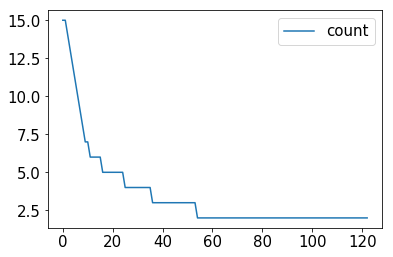

In [372]:
#distribution of no. of articles for a single topic
input_df.plot(y='count', use_index=True)

## a) Impact on NASDAQ 100 Technology Sector (^NDXT)

In [373]:
#Data from yahoo finance
ndxt_df = pd.read_csv(cwd+'/Data/17-18_NDXT.csv')
ndxt_df.dropna(axis=0, inplace=True)
ndxt_df['Date'] = pd.to_datetime(ndxt_df['Date'])
#add closing hour: 4pm
ndxt_df['Date'] = ndxt_df['Date'] + timedelta(hours=16)
ndxt_df['Change'] = ndxt_df['Close'] - ndxt_df.shift(1)['Close']
ndxt_df['Change_%'] = ndxt_df['Close']/ndxt_df.shift(1)['Close']-1
ndxt_df['Day_Change'] = ndxt_df['Close'] - ndxt_df['Open']
ndxt_df['Day_Change(%)'] = (ndxt_df['Close']/ndxt_df['Open']-1)*100

In [374]:
start = input_df['publishedAt'].min()
end = input_df['publishedAt'].max()
print (start, end)

2018-10-22 08:00:00 2018-11-20 21:42:10


In [375]:
NT_df = ndxt_df[(ndxt_df['Date']>=start) & (ndxt_df['Date'] <= end)]
NT_df.reset_index(drop=True,inplace=True)
NT_df

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Change_%,Day_Change,Day_Change(%)
0,2018-10-22 16:00:00,3988.500000,4004.399902,3951.780029,3983.080078,3983.080078,0,22.330078,0.005638,-5.419922,-0.135889
1,2018-10-23 16:00:00,3898.110107,4005.209961,3873.590088,3986.300049,3986.300049,0,3.219971,0.000808,88.189942,2.262377
2,2018-10-24 16:00:00,3945.889893,3955.469971,3769.989990,3772.889893,3772.889893,0,-213.410156,-0.053536,-173.000000,-4.384309
3,2018-10-25 16:00:00,3832.959961,3919.149902,3831.159912,3893.429932,3893.429932,0,120.540039,0.031949,60.469971,1.577631
4,2018-10-26 16:00:00,3751.209961,3857.379883,3727.699951,3792.570068,3792.570068,0,-100.859864,-0.025905,41.360107,1.102580
5,2018-10-29 16:00:00,3867.649902,3869.909912,3673.199951,3739.989990,3739.989990,0,-52.580078,-0.013864,-127.659912,-3.300710
6,2018-10-30 16:00:00,3741.330078,3818.070068,3733.469971,3815.669922,3815.669922,0,75.679932,0.020235,74.339844,1.986990
7,2018-10-31 16:00:00,3875.110107,3925.699951,3863.840088,3899.090088,3899.090088,0,83.420166,0.021863,23.979981,0.618821
8,2018-11-01 16:00:00,3906.659912,4015.090088,3890.959961,4011.989990,4011.989990,0,112.899902,0.028955,105.330078,2.696167
9,2018-11-02 16:00:00,4019.050049,4030.979980,3935.169922,3970.929932,3970.929932,0,-41.060058,-0.010234,-48.120117,-1.197301


In [376]:
#Get closest trading date according to publish date
#Reference:  https://stackoverflow.com/questions/39105282/how-to-find-min-value-of-another-column-greater-than-current-column-pandas
def NT_findMin_idx(x):
    larger = NT_df[NT_df['Date']>x]['Date']
    if len(larger) !=0:
        return larger.idxmin()
    else:
        return np.nan #if no article is too new and no market data avliable yet

In [377]:
for i, r in input_df.iterrows():
    Min_idx = NT_findMin_idx(r['publishedAt'])
    if np.isnan(Min_idx): continue
    input_df.at[i,'Trading_day'] = NT_df.loc[Min_idx,'Date']
    # Define impact as the magntudde of change
    input_df.at[i,'Impact'] = NT_df.loc[Min_idx,'Change']

/Users/josehui/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/josehui/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [378]:
#rank by change magnitude + number of mentioning
input_df['abs'] = input_df['Impact'].abs()
ranked_df = input_df.sort_values(['abs', 'count'], ascending = False)
ranked_df.drop('abs', axis=1, inplace=True)
ranked_df.reset_index(drop=True, inplace=True)
ranked_df.head()

/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,author,content,description,publishedAt,source,title,url,urlToImage,count,Trading_day,Impact
0,ANNABELLE LIANG,SINGAPORE (AP) Asian markets were mixed on Wed...,SINGAPORE (AP) — Asian markets were mixed on W...,2018-10-24 06:25:48,"{'id': None, 'name': 'Seattletimes.com'}",Asian markets mixed as US businesses caution a...,https://www.seattletimes.com/business/asian-ma...,https://static.seattletimes.com/wp-content/upl...,10,2018-10-24 16:00:00,-213.410156
1,Amy Caren Daniel,"(Reuters) - Wall Street sank on Tuesday, conti...","Wall Street sank on Tuesday, continuing a puni...",2018-10-23 17:16:19,"{'id': 'reuters', 'name': 'Reuters'}",Wall Street sinks as weak forecasts add to dou...,https://www.reuters.com/article/us-usa-stocks/...,https://s4.reutersmedia.net/resources/r/?m=02&...,7,2018-10-24 16:00:00,-213.410156
2,Amy Caren Daniel,(Reuters) - The Dow Jones Industrial Average r...,The Dow Jones Industrial Average rose on Wedne...,2018-10-24 13:56:22,"{'id': 'reuters', 'name': 'Reuters'}","Boeing lifts Dow, but chipmakers pose headwind",https://www.reuters.com/article/us-usa-stocks/...,https://s4.reutersmedia.net/resources/r/?m=02&...,4,2018-10-24 16:00:00,-213.410156
3,The Associated Press,U.S. stocks declined in early trading Wednesda...,"Get breaking national and world news, broadcas...",2018-10-24 14:15:12,"{'id': 'abc-news', 'name': 'ABC News'}",US stocks edge lower as traders weigh earnings...,https://abcnews.go.com/Business/wireStory/us-s...,https://s.abcnews.com/images/Business/WireAP_5...,2,2018-10-24 16:00:00,-213.410156
4,FinancialBuzz.com,"NEW YORK, October 24, 2018 /PRNewswire/ -- Acc...","NEW YORK, October 24, 2018 /PRNewswire/ -- Acc...",2018-10-24 13:00:00,"{'id': None, 'name': 'Prnewswire.com'}",The Cryptocurrency ATM Market is set to Expand...,https://www.prnewswire.com/news-releases/the-c...,/content/dam/prnewswire/common/prn_facebook_sh...,2,2018-10-24 16:00:00,-213.410156


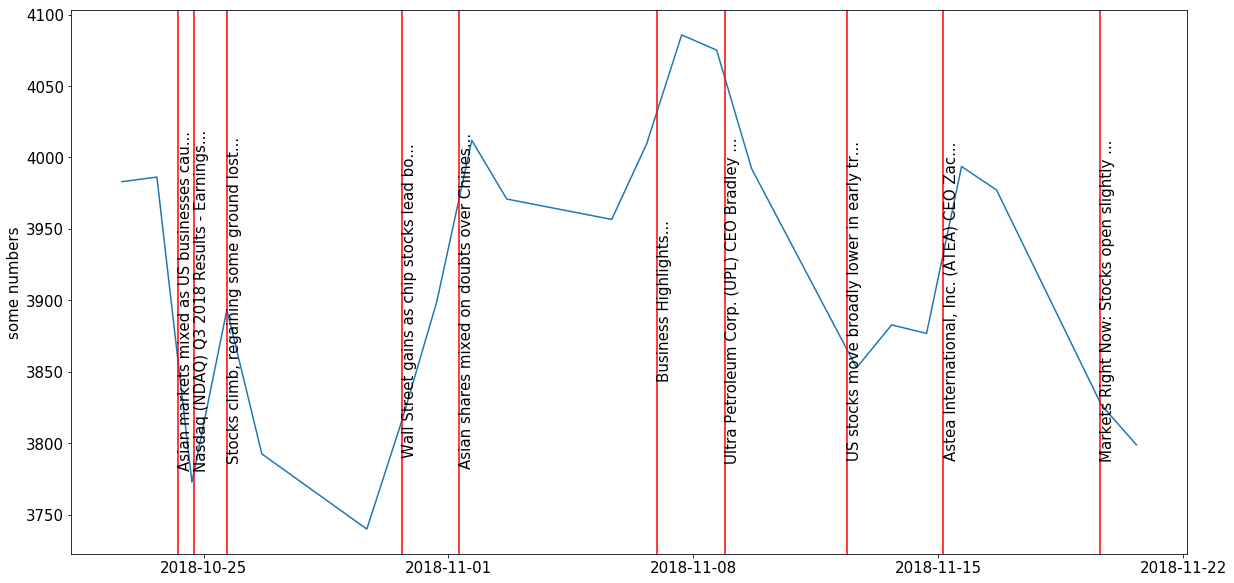

In [379]:
matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(20,10))
plt.plot(NT_df['Date'],NT_df['Close'])
plt.ylabel('some numbers')
# draw vertical lines for top topics
for i, r in ranked_df.drop_duplicates('Trading_day').head(10).iterrows():
    d = r['publishedAt']
    plt.axvline(x=d , color='r')
    #label
    plt.text(d, 3900, r['title'][:40]+'...', rotation=90, verticalalignment='center')
plt.show()

## Ouput ranking 

In [380]:
ranked_df.index += 1 
ranked_df.index.names = ['Rank']
ranked_df.to_excel(cwd+'/Result/2018-11-21_NDXT_impact.xlsx')

## b) Impact on NASDAQ Composite (^IXIC)

In [399]:
#Data from yahoo finance
ixic_df = pd.read_csv(cwd+'/Data/17-18_IXIC.csv')
ixic_df.dropna(axis=0, inplace=True)
ixic_df['Date'] = pd.to_datetime(ixic_df['Date'])
#add closing hour: 4pm
ixic_df['Date'] = ixic_df['Date'] + timedelta(hours=16)
ixic_df['Change'] = ixic_df['Close'] - ixic_df.shift(1)['Close']
ixic_df['Change_%'] = ixic_df['Close']/ixic_df.shift(1)['Close']-1
ixic_df['Day_Change'] = ixic_df['Close'] - ixic_df['Open']
ixic_df['Day_Change(%)'] = (ixic_df['Close']/ixic_df['Open']-1)*100

In [400]:
start = input_df['publishedAt'].min()
end = input_df['publishedAt'].max()
print (start, end)

2018-10-22 02:31:22 2018-11-20 07:17:34


In [401]:
IC_df = ixic_df[(ixic_df['Date']>=start) & (ixic_df['Date'] <= end)]
IC_df.reset_index(drop=True,inplace=True)
IC_df

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Change_%,Day_Change,Day_Change(%)
0,2018-10-22 16:00:00,7486.740234,7520.540039,7424.740234,7468.629883,7468.629883,2282400000,NaN,NaN,-18.110351,-0.241899
1,2018-10-23 16:00:00,7328.549805,7472.580078,7260.129883,7437.540039,7437.540039,2735820000,-31.089844,-0.004163,108.990234,1.487201
2,2018-10-24 16:00:00,7423.209961,7435.689941,7099.000000,7108.399902,7108.399902,2935550000,-329.140137,-0.044254,-314.810059,-4.240889
3,2018-10-25 16:00:00,7197.490234,7364.819824,7178.540039,7318.339844,7318.339844,2741810000,209.939942,0.029534,120.849610,1.679052
4,2018-10-26 16:00:00,7125.180176,7283.319824,7057.000000,7167.209961,7167.209961,2964780000,-151.129883,-0.020651,42.029785,0.589877
5,2018-10-29 16:00:00,7272.419922,7295.609863,6922.830078,7050.290039,7050.290039,2689550000,-116.919922,-0.016313,-222.129883,-3.054415
6,2018-10-30 16:00:00,7017.870117,7166.839844,7001.479980,7161.649902,7161.649902,2681310000,111.359863,0.015795,143.779785,2.048767
7,2018-10-31 16:00:00,7276.620117,7368.490234,7270.629883,7305.899902,7305.899902,2899730000,144.250000,0.020142,29.279785,0.402382
8,2018-11-01 16:00:00,7327.819824,7435.879883,7286.500000,7434.060059,7434.060059,2708880000,128.160157,0.017542,106.240235,1.449821
9,2018-11-02 16:00:00,7424.020020,7466.529785,7298.680176,7356.990234,7356.990234,2889910000,-77.069825,-0.010367,-67.029786,-0.902877


In [384]:
#Get closest trading date according to publish date
#Reference:  https://stackoverflow.com/questions/39105282/how-to-find-min-value-of-another-column-greater-than-curreIC-column-pandas
def IC_findMin_idx(x):
    larger = IC_df[IC_df['Date']>x]['Date']
    if len(larger) !=0:
        return larger.idxmin()
    else:
        return np.nan #if no article is too new and no market data avliable yet

In [385]:
for i, r in input_df.iterrows():
    Min_idx = IC_findMin_idx(r['publishedAt'])
    if np.isnan(Min_idx): continue
    input_df.at[i,'Trading_day'] = IC_df.loc[Min_idx,'Date']
    # Define impact as the magICudde of change
    input_df.at[i,'Impact'] = IC_df.loc[Min_idx,'Change']

In [386]:
#rank by change magnitude + number of mentioning
input_df['abs'] = input_df['Impact'].abs()
ranked_df = input_df.sort_values(['abs', 'count'], ascending = False)
ranked_df.drop('abs', axis=1, inplace=True)
ranked_df.reset_index(drop=True, inplace=True)
ranked_df.head()

/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,author,content,description,publishedAt,source,title,url,urlToImage,count,Trading_day,Impact
0,ANNABELLE LIANG,SINGAPORE (AP) Asian markets were mixed on Wed...,SINGAPORE (AP) — Asian markets were mixed on W...,2018-10-24 06:25:48,"{'id': None, 'name': 'Seattletimes.com'}",Asian markets mixed as US businesses caution a...,https://www.seattletimes.com/business/asian-ma...,https://static.seattletimes.com/wp-content/upl...,10,2018-10-24 16:00:00,-329.140137
1,Amy Caren Daniel,"(Reuters) - Wall Street sank on Tuesday, conti...","Wall Street sank on Tuesday, continuing a puni...",2018-10-23 17:16:19,"{'id': 'reuters', 'name': 'Reuters'}",Wall Street sinks as weak forecasts add to dou...,https://www.reuters.com/article/us-usa-stocks/...,https://s4.reutersmedia.net/resources/r/?m=02&...,7,2018-10-24 16:00:00,-329.140137
2,Amy Caren Daniel,(Reuters) - The Dow Jones Industrial Average r...,The Dow Jones Industrial Average rose on Wedne...,2018-10-24 13:56:22,"{'id': 'reuters', 'name': 'Reuters'}","Boeing lifts Dow, but chipmakers pose headwind",https://www.reuters.com/article/us-usa-stocks/...,https://s4.reutersmedia.net/resources/r/?m=02&...,4,2018-10-24 16:00:00,-329.140137
3,The Associated Press,U.S. stocks declined in early trading Wednesda...,"Get breaking national and world news, broadcas...",2018-10-24 14:15:12,"{'id': 'abc-news', 'name': 'ABC News'}",US stocks edge lower as traders weigh earnings...,https://abcnews.go.com/Business/wireStory/us-s...,https://s.abcnews.com/images/Business/WireAP_5...,2,2018-10-24 16:00:00,-329.140137
4,FinancialBuzz.com,"NEW YORK, October 24, 2018 /PRNewswire/ -- Acc...","NEW YORK, October 24, 2018 /PRNewswire/ -- Acc...",2018-10-24 13:00:00,"{'id': None, 'name': 'Prnewswire.com'}",The Cryptocurrency ATM Market is set to Expand...,https://www.prnewswire.com/news-releases/the-c...,/content/dam/prnewswire/common/prn_facebook_sh...,2,2018-10-24 16:00:00,-329.140137


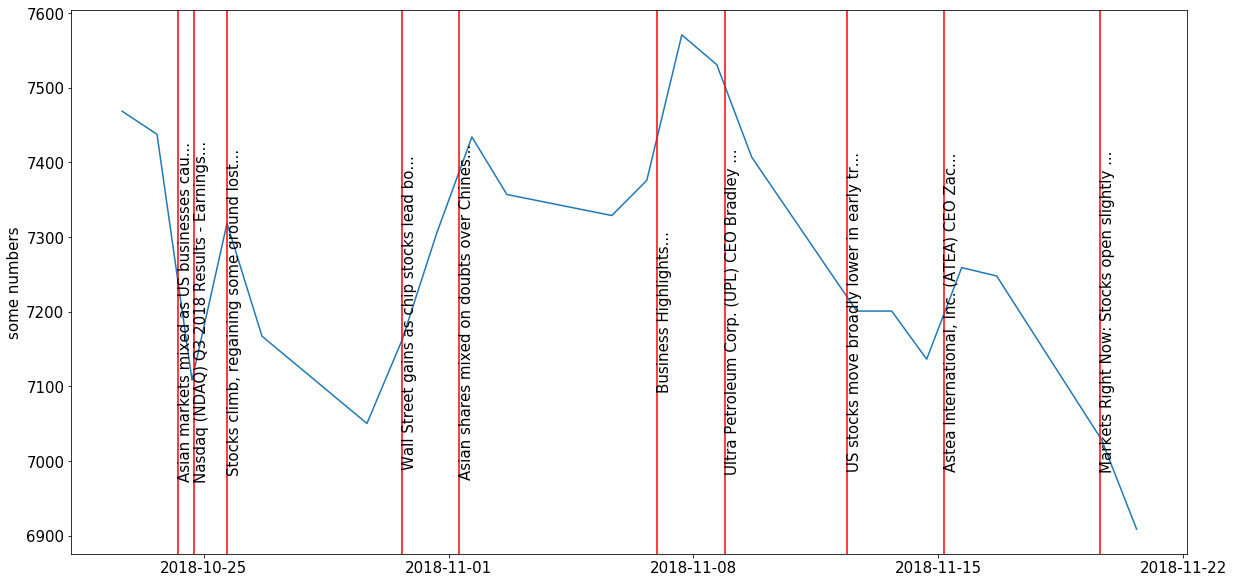

In [387]:
matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(20,10))
plt.plot(IC_df['Date'],IC_df['Close'])
plt.ylabel('some numbers')
# draw vertical lines for top topics
for i, r in ranked_df.drop_duplicates('Trading_day').head(10).iterrows():
    d = r['publishedAt']
    plt.axvline(x=d , color='r')
    #label 
    plt.text(d, 7200, r['title'][:40]+'...', rotation=90, verticalalignment='center')
plt.show()

## Ouput ranking 

In [388]:
ranked_df.index += 1 
ranked_df.index.names = ['Rank']
ranked_df.to_excel(cwd+'/Result/2018-11-21_IXIC_impact.xlsx')

## HK region

In [389]:
s_df = pd.read_csv(cwd+'/Output/2018-11-21_Hong Kong news_output(tf-idf).csv',index_col=0)
s_df['publishedAt'] = pd.to_datetime(s_df['publishedAt'])
display(s_df.head(10))
print (s_df.shape)
#Exclude articles with only one mentioning
input_df = s_df[s_df['count']>1]
input_df.sort_values('count',ascending=False, inplace=True)
input_df.reset_index(drop=True, inplace=True)
display(input_df.head(10))
print (input_df.shape)

,author,content,description,publishedAt,source,title,url,urlToImage,count
0,"Clark Mindock, Clark Mindock",With the 2018 midterm elections just over two ...,The midterms are just weeks away in early Nove...,2018-10-20 01:47:04,"{'id': 'independent', 'name': 'Independent'}",Midterm election glossary: The terms you need ...,https://www.independent.co.uk/news/world/ameri...,https://static.independent.co.uk/s3fs-public/t...,1
1,"Toyin Owoseje, Toyin Owoseje",Africa s youngest billionaire Mohammed Dewji h...,"'I thank all my fellow Tanzanians, and everyon...",2018-10-20 08:20:46,"{'id': 'independent', 'name': 'Independent'}",Mohammed Dewji: Africa's youngest billionaire ...,https://www.independent.co.uk/news/world/afric...,https://static.independent.co.uk/s3fs-public/t...,1
2,NaN,"The Guardian / Lagos, Nigeria AFRICAN LEADERSH...",“It is ... disheartening to observe that not e...,2018-10-20 10:00:01,"{'id': None, 'name': 'Yahoo.com'}","African leadership should speak out at the UN,...",https://www.yahoo.com/news/african-leadership-...,https://s.yimg.com/os/mit/media/m/social/image...,1
3,"Toyin Owoseje, Toyin Owoseje",The Mega Millions jackpot has surged to a stag...,"The winning numbers were 15, 23, 53, 65, 70 an...",2018-10-20 11:43:36,"{'id': 'independent', 'name': 'Independent'}",Mega Millions lottery jackpot climbs to $1.6bi...,https://www.independent.co.uk/news/world/ameri...,https://static.independent.co.uk/s3fs-public/t...,1
4,"Eli Rosenberg, Eli Rosenberg",A group of hecklers angrily confronted House M...,"Some 40 protestors hurled insults at Pelosi, i...",2018-10-20 12:05:26,"{'id': 'independent', 'name': 'Independent'}",Midterm elections: Far-right hecklers confront...,https://www.independent.co.uk/news/world/ameri...,https://static.independent.co.uk/s3fs-public/t...,1
5,"Saman Javed, Saman Javed",At least 15 people have been killed after a su...,The Taliban has issued numerous statements war...,2018-10-20 15:41:52,"{'id': 'independent', 'name': 'Independent'}",At least 15 killed by suicide bomber at pollin...,https://www.independent.co.uk/news/world/asia/...,https://static.independent.co.uk/s3fs-public/t...,1
6,"Peter Yeung, Peter Yeung",When Britain handed Hong Kong back to Chinese ...,A number of moves by China have led some to pr...,2018-10-20 16:02:00,"{'id': 'independent', 'name': 'Independent'}",'It's a dark time': Fears Hong Kong is losing ...,https://www.independent.co.uk/news/world/asia/...,https://static.independent.co.uk/s3fs-public/t...,1
7,"Toyin Owoseje, Toyin Owoseje",A lake in northern Greece has been transformed...,'Weather conditions are ideal for them to mult...,2018-10-20 16:06:00,"{'id': 'independent', 'name': 'Independent'}","Giant 1,000m spider web covers Greek lake",https://www.independent.co.uk/news/world/europ...,https://static.independent.co.uk/s3fs-public/t...,1
8,"Andrew Buncombe, Andrew Buncombe","Richard Nixon was born in this town, and his b...","'If we don't step up, things are going to get ...",2018-10-20 16:48:38,"{'id': 'independent', 'name': 'Independent'}",Midterm elections: Inside the Democrats' battl...,https://www.independent.co.uk/news/world/ameri...,https://static.independent.co.uk/s3fs-public/t...,1
9,"Saman Javed, Saman Javed",A far-right German politician has resigned aft...,"In the pictures, he poses near swastikas, SS r...",2018-10-20 17:30:00,"{'id': 'independent', 'name': 'Independent'}",Far-right German politician resigns after bein...,https://www.independent.co.uk/news/world/europ...,https://static.independent.co.uk/s3fs-public/t...,1


(803, 9)


/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,author,content,description,publishedAt,source,title,url,urlToImage,count
0,Star Tribune Staff,HONG KONG Concerns have been raised about free...,Concerns have been raised about freedom of exp...,2018-11-09 20:15:00,"{'id': None, 'name': 'Startribune.com'}","Events canceled, editor expelled: Hong Kong's ...",http://www.startribune.com/events-canceled-edi...,http://assets.startribune.com/static/img/brand...,11
1,James Pomfret,HONG KONG (Reuters) - Hong Kong organizers of ...,Hong Kong organizers of an exhibition by a dis...,2018-11-02 12:41:51,"{'id': 'reuters', 'name': 'Reuters'}",Dissident cartoonist cancels Hong Kong show af...,https://www.reuters.com/article/us-hongkong-ch...,https://s4.reutersmedia.net/resources_v2/image...,9
2,https://www.dailymail.co.uk/home/search.html?s...,"By Sujata Rao LONDON, Nov 7 (Reuters) - Wall S...","By Sujata RaoLONDON, Nov 7 (Reuters) - Wall St...",2018-11-07 09:38:41,"{'id': 'daily-mail', 'name': 'Daily Mail'}","Dollar, U.S. bond yields fall, stocks inch hig...",https://www.dailymail.co.uk/wires/reuters/arti...,https://i.dailymail.co.uk/i/pix/m_logo_636x382...,9
3,NaN,Ultra mode displays 3 times the news on this p...,The Internet on one page. Successor of Popurls...,2018-11-19 12:17:08,"{'id': None, 'name': 'Hvper.com'}",Members of the multi-billionaire philanthropi...,http://www.hvper.com/?ref=feed_716d98fb3ff485b...,http://www.hvper.com/static/img/og_09.png,8
4,newsfeedback@fool.com (Motley Fool Transcription),Image source: The Motley Fool. TransUnion ( NY...,TRU earnings call for the period ending Septem...,2018-10-23 17:57:08,"{'id': None, 'name': 'Fool.com'}",TransUnion (TRU) Q3 2018 Earnings Conference C...,https://www.fool.com/earnings/call-transcripts...,https://g.foolcdn.com/image/?url=https%3A%2F%2...,8
5,Reuters Editorial,HONG KONG (Reuters) - Hong Kong barred the Asi...,Hong Kong barred the Asia news editor of the F...,2018-11-09 03:47:28,"{'id': 'reuters', 'name': 'Reuters'}",Hong Kong bars British editor from entering ci...,https://af.reuters.com/article/worldNews/idAFK...,https://s4.reutersmedia.net/resources/r/?m=02&...,7
6,NaN,Ultra mode displays 3 times the news on this p...,The Internet on one page. Successor of Popurls...,2018-11-19 08:37:07,"{'id': None, 'name': 'Hvper.com'}",Calling Out Racist Voters Is Satisfying. But ...,http://www.hvper.com/?ref=feed_23cff0661a0ebf6...,http://www.hvper.com/static/img/og_09.png,7
7,Bangkok Post Public Company Limited,HONG KONG - Hong Kong carrier Cathay Pacific c...,HONG KONG - Hong Kong carrier Cathay Pacific c...,2018-10-25 06:45:16,"{'id': None, 'name': 'Bangkokpost.com'}",Questions mount over delay after Cathay Pacifi...,https://www.bangkokpost.com/news/world/1564370...,https://www.bangkokpost.com/media/content/2018...,7
8,Bangkok Post Public Company Limited,A large screen displays a message indicating s...,Alibaba Group logged 10 billion yuan (47.5 bil...,2018-11-11 07:44:00,"{'id': None, 'name': 'Bangkokpost.com'}",Alibaba sets sales record for opening minutes ...,https://www.bangkokpost.com/business/world/157...,https://www.bangkokpost.com/media/content/2018...,7
9,https://www.dailymail.co.uk/home/search.html?s...,By Sumeet Chatterjee and Engen Tham HONG KONG/...,By Sumeet Chatterjee and Engen ThamHONG KONG/S...,2018-10-24 07:38:24,"{'id': 'daily-mail', 'name': 'Daily Mail'}",A banker's woe: Chinese wealth may get harder ...,https://www.dailymail.co.uk/wires/reuters/arti...,https://i.dailymail.co.uk/i/pix/m_logo_636x382...,6


(84, 9)


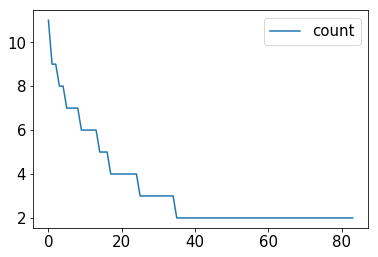

In [390]:
#distribution of no. of articles for a single topic
input_df.plot(y='count', use_index=True)

## Impact on Hang Seng Index (^HSI)

In [391]:
#Data from yahoo finance
hsi_df = pd.read_csv(cwd+'/Data/17-18_HSI.csv')
hsi_df.dropna(axis=0, inplace=True)
hsi_df['Date'] = pd.to_datetime(hsi_df['Date'])
#add closing hour: 4pm
hsi_df['Date'] = hsi_df['Date'] + timedelta(hours=16)
hsi_df['Change'] = hsi_df['Close'] - hsi_df.shift(1)['Close']
hsi_df['Change_%'] = hsi_df['Close']/hsi_df.shift(1)['Close']-1
hsi_df['Day_Change'] = hsi_df['Close'] - hsi_df['Open']
hsi_df['Day_Change(%)'] = (hsi_df['Close']/hsi_df['Open']-1)*100

In [392]:
start = input_df['publishedAt'].min()
end = input_df['publishedAt'].max()
print (start, end)

2018-10-22 02:31:22 2018-11-20 07:17:34


In [393]:
H_df = hsi_df[(hsi_df['Date']>=start) & (hsi_df['Date'] <= end)]
H_df.reset_index(drop=True,inplace=True)
H_df

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Change_%,Day_Change,Day_Change(%)
0,2018-10-22 16:00:00,25668.330078,26234.859375,25668.330078,26153.150391,26153.150391,2.222812e+09,591.750000,0.023150,484.820313,1.888788
1,2018-10-23 16:00:00,26015.490234,26015.490234,25315.759766,25346.550781,25346.550781,1.772912e+09,-806.599610,-0.030841,-668.939453,-2.571312
2,2018-10-24 16:00:00,25401.169922,25653.359375,25194.289063,25249.779297,25249.779297,1.962754e+09,-96.771484,-0.003818,-151.390625,-0.595999
3,2018-10-25 16:00:00,24766.720703,24994.460938,24653.789063,24994.460938,24994.460938,2.288634e+09,-255.318359,-0.010112,227.740235,0.919541
4,2018-10-26 16:00:00,25031.490234,25062.199219,24589.039063,24717.630859,24717.630859,1.688396e+09,-276.830079,-0.011076,-313.859375,-1.253858
5,2018-10-29 16:00:00,24955.789063,24955.789063,24594.740234,24812.039063,24812.039063,2.000986e+09,94.408204,0.003819,-143.750000,-0.576019
6,2018-10-30 16:00:00,24765.119141,24939.179688,24540.630859,24585.529297,24585.529297,2.100388e+09,-226.509766,-0.009129,-179.589844,-0.725173
7,2018-10-31 16:00:00,24752.830078,24979.689453,24700.109375,24979.689453,24979.689453,2.363084e+09,394.160156,0.016032,226.859375,0.916499
8,2018-11-01 16:00:00,25228.750000,25535.119141,25190.900391,25416.000000,25416.000000,2.176973e+09,436.310547,0.017467,187.250000,0.742209
9,2018-11-02 16:00:00,25980.439453,26486.349609,25909.710938,26486.349609,26486.349609,3.518979e+09,1070.349609,0.042113,505.910156,1.947273


In [394]:
#Get closest trading date according to publish date
#Reference:  https://stackoverflow.com/questions/39105282/how-to-find-min-value-of-another-column-greater-than-current-column-pandas
def H_findMin_idx(x):
    larger = H_df[H_df['Date']>x]['Date']
    if len(larger) !=0:
        return larger.idxmin()
    else:
        return np.nan #if no article is too new and no market data avliable yet

In [395]:
for i, r in input_df.iterrows():
    Min_idx = H_findMin_idx(r['publishedAt'])
    if np.isnan(Min_idx): continue
    input_df.at[i,'Trading_day'] = H_df.loc[Min_idx,'Date']
    # Define impact as the magntudde of change
    input_df.at[i,'Impact'] = H_df.loc[Min_idx,'Change']

/Users/josehui/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/josehui/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [396]:
#rank by change magnitude + number of mentioning
input_df['abs'] = input_df['Impact'].abs()
ranked_df = input_df.sort_values(['abs', 'count'], ascending = False)
ranked_df.drop('abs', axis=1, inplace=True)
ranked_df.reset_index(drop=True, inplace=True)
ranked_df.head()

/Users/josehui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,author,content,description,publishedAt,source,title,url,urlToImage,count,Trading_day,Impact
0,James Pomfret,HONG KONG (Reuters) - Hong Kong organizers of ...,Hong Kong organizers of an exhibition by a dis...,2018-11-02 12:41:51,"{'id': 'reuters', 'name': 'Reuters'}",Dissident cartoonist cancels Hong Kong show af...,https://www.reuters.com/article/us-hongkong-ch...,https://s4.reutersmedia.net/resources_v2/image...,9,2018-11-02 16:00:00,1070.349609
1,"Jenny Leonard, Saleha Mohsin and Jennifer Jaco...",President Donald Trump wants to reach an agree...,It was unclear if Trump was easing up on US de...,2018-11-02 08:55:00,"{'id': None, 'name': 'Business-standard.com'}",US-China trade spat to end? Trump keen on lock...,https://www.business-standard.com/article/inte...,https://bsmedia.business-standard.com/_media/b...,4,2018-11-02 16:00:00,1070.349609
2,"James Griffiths, CNN",Hong Kong (CNN) An art show in Hong Kong featu...,An art show in Hong Kong featuring the work of...,2018-11-02 08:51:23,"{'id': 'cnn', 'name': 'CNN'}",Chinese dissident artist's Hong Kong show canc...,https://www.cnn.com/2018/11/02/asia/badiucao-c...,https://cdn.cnn.com/cnnnext/dam/assets/1703221...,4,2018-11-02 16:00:00,1070.349609
3,NaN,Chinese electric-vehicle developer Faraday Fut...,Faraday Future has begun exploring strategic o...,2018-11-02 01:17:15,"{'id': None, 'name': 'Autonews.com'}","China's Faraday Future, strapped for cash, exp...",http://europe.autonews.com/article/20181101/CO...,http://www.autonews.com/apps/pbcsi.dll/storyim...,2,2018-11-02 16:00:00,1070.349609
4,Hindenburg Investment Research,"Overview In October 2016, Genworth ( GNW ) ann...","Genworth’s proposed acquirer, China Oceanwide,...",2018-11-01 17:00:00,"{'id': None, 'name': 'Seekingalpha.com'}",Genworth: We See Almost No Chance Of Regulator...,https://seekingalpha.com/article/4216921-genwo...,https://static1.seekingalpha.com/images/market...,2,2018-11-02 16:00:00,1070.349609


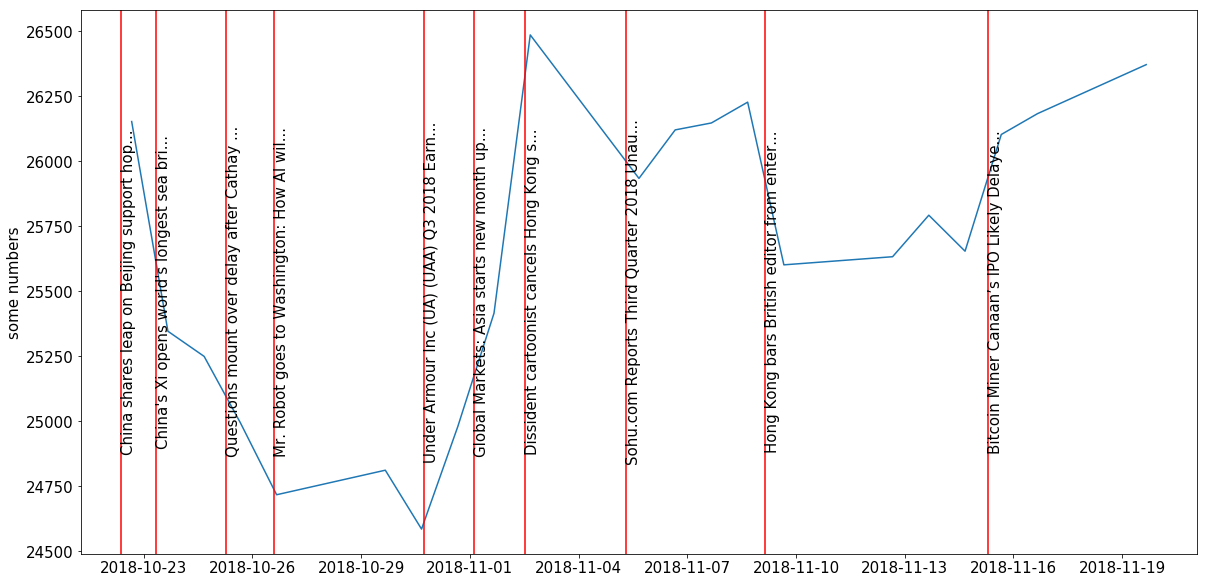

In [397]:
matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(20,10))
plt.plot(H_df['Date'],H_df['Close'])
plt.ylabel('some numbers')
# draw vertical lines for top topics
for i, r in ranked_df.drop_duplicates('Trading_day').head(10).iterrows():
    d = r['publishedAt']
    plt.axvline(x=d , color='r')
    #label
    plt.text(d, 25500, r['title'][:40]+'...', rotation=90, verticalalignment='center')
plt.show()

## Ouput ranking 
hsi_df = pd.read_csv(cwd+'/Data/17-18_HSI.csv')
hsi_df.dropna(axis=0, inplace=True)
hsi_df['Date'] = pd.to_datetime(hsi_df['Date'])
#add closing hour: 4pm
hsi_df['Date'] = hsi_df['Date'] + timedelta(hours=16)
hsi_df['Change'] = hsi_df['Close'] - hsi_df.shift(1)['Close']
hsi_df['Change_%'] = hsi_df['Close']/hsi_df.shift(1)['Close']-1
hsi_df['Day_Change'] = hsi_df['Close'] - hsi_df['Open']
hsi_df['Day_Change_%'] = hsi_df['Close']/hsi_df['Open']-1

## Ouput ranking 

In [398]:
ranked_df.index += 1 
ranked_df.index.names = ['Rank']
ranked_df.to_excel(cwd+'/Result/2018-11-21_HSI_impact.xlsx')

/Users/josehui/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'https://i.guim.co.uk/img/media/8c284af42f7e47cb9095e789adbaee49ab22812e/0_384_5760_3456/master/5760.jpg?width=1200&height=630&quality=85&auto=format&fit=crop&overlay-align=bottom%2Cleft&overlay-width=100p&overlay-base64=L2ltZy9zdGF0aWMvb3ZlcmxheXMvdGctZGVmYXVsdC5wbmc&s=54898429e0da3479061368cc137a1788' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
